# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import networkx as nx
import warnings
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import torch
import os
import string
import itertools
from tqdm import tqdm

In [2]:
import json
import copy

# Load your usual SpaCy model (one of SpaCy English models)
import spacy
import re
nlp = spacy.load('en_core_web_lg')

# Add neural coref to SpaCy's pipeline
import neuralcoref
neuralcoref.add_to_pipe(nlp)

In [264]:
SEED = 74

In [25]:
dp = DocPreProcessor(
"""
Miley Ray Cyrus (/ˈmaɪliː ˈsaɪrəs/ MY-lee-SYE-rəs; born Destiny Hope Cyrus, November 23, 1992) is an American singer, songwriter, actress, and television personality. Known for her distinctive raspy voice,[2][3] her music incorporates elements of varied styles and genres, including pop, country pop, hip hop, experimental, and rock. She has attained the most US Billboard 200 top-five albums in the 21st century by a female artist, with a total of thirteen entries.

Destiny Hope Cyrus was born November 23, 1992, in Franklin, Tennessee,[7] to Leticia "Tish" Jean Cyrus (née Finley) and country singer Billy Ray Cyrus.[7] She was born with supraventricular tachycardia, a condition causing an abnormal resting heart rate.[8] Her birth name, Destiny Hope, expressed her parents' belief that she would accomplish great things. Her parents nicknamed her "Smiley", which they later shortened to "Miley", because she often smiled as an infant.[9] In 2008, she legally changed her name to Miley Ray Cyrus; her middle name honors her grandfather, Democratic politician Ronald Ray Cyrus who was from Kentucky.[10] Cyrus's godmother is singer-songwriter Dolly Parton.[11]

Against the advice of her father's record company,[12] Cyrus's parents secretly married on December 28, 1993, a year after her birth.[13] They had two more children together, son Braison and daughter Noah.[14] From previous relationships, her mother has two other children, Brandi and Trace.[15] Her father's first child, Christopher Cody, was born in April 1992[13] and grew up with his mother, Kristin Luckey, in South Carolina.[12]
""")

In [27]:
clusters = dp.spacy_doc._.coref_clusters
clusters

[
 Miley Ray Cyrus: [
 Miley Ray Cyrus, her, her, She, Destiny Hope Cyrus, She, Her, her, she, Her, her, she, she, her, her, her, Cyrus],
 her parents': [her parents', Her parents, they],
 Miley Ray Cyrus: [Miley Ray Cyrus, Cyrus],
 Cyrus's godmother: [Cyrus's godmother, her, her, her],
 her father: [her father, Her father, his],
 Cyrus's parents: [Cyrus's parents, They],
 Brandi: [Brandi, Her]]

In [33]:
print(clusters[2].mentions[0].start_char, clusters[2].mentions[0].end_char)

875 890


In [122]:
# check this test = nlp("Bassett was born in New York City, the daughter of a social worker Betty Jane, a civil servant, and Daniel Benjamin Bassett, a preacher's son. Bassett's middle name was given to her in honor of her aunt Evelyn. Ten months after Bassett was born, her mother became pregnant and had a second child, Bassett's sister D'nette. Bassett said the pregnancy \"only made things harder\", leading her parents to send her to her father's sister, Golden, in Winston-Salem, North Carolina. While her aunt did not have any children of her own, she \"loved children, and she was good with them.\"\n\nBassett married actor Courtney B. Vance in 1997. In the summer of 2005, they starred together in a production of His Girl Friday at the Guthrie Theater in Minneapolis, Minnesota. The couple's twins – son Slater Josiah Vance and daughter Bronwyn Golden Vance – were carried by a surrogate.")
# test = nlp("Hillary Diane Rodham was born on October 26, 1947, at Edgewater Medical Center in Chicago, Illinois. She was raised in a United Methodist family who first lived in Chicago. When she was three years old, her family moved to the Chicago suburb of Park Ridge. Her father, Hugh Rodham, was of English and Welsh descent, and managed a small but successful textile business, which he had founded. Her mother, Dorothy Howell, was a homemaker of Dutch, English, French Canadian, Scottish, and Welsh descent. She had two younger brothers, Hugh and Tony.\n\nOn February 27, 1980, Rodham gave birth to the couple's only child, a daughter whom they named Chelsea. In November 1980, Bill Clinton was defeated in his bid for re-election.")
# test = nlp("Grace Brewster Murray was born in New York City. She was the eldest of three children. Her parents, Walter Fletcher Murray and Mary Campbell Van Horne, were of Scottish and Dutch descent, and attended West End Collegiate Church. Her great-grandfather, Alexander Wilson Russell, an admiral in the US Navy, fought in the Battle of Mobile Bay during the Civil War.\n\nIn 1930 Grace Murray married New York University professor Vincent Foster Hopper; they divorced in 1945. Although she did not marry again, she retained his surname.")
# test = nlp("Born Louis Bernstein in Lawrence, Massachusetts, he was the son of Ukrainian-Jewish parents, Jennie and Samuel Joseph Bernstein, both of whom immigrated to the United States from Rovno. His grandmother insisted that his first name be Louis, but his parents always called him Leonard. He legally changed his name to Leonard when he was eighteen, shortly after his grandmother's death. To his friends and many others he was simply known as \"Lenny\".\n\nIn Leonard's early youth, his only exposure to music was the household radio and music on Friday nights at Congregation Mishkan Tefila in Roxbury, Massachusetts. When Leonard was ten years old, Samuel's sister Clara deposited her upright piano at her brother's house. Bernstein began teaching himself piano and music theory and was soon clamoring for lessons. He had a variety of piano teachers in his youth, including Helen Coates, who later became his secretary. In the summers, the Bernstein family would go to their vacation home in Sharon, Massachusetts, where young Leonard conscripted all the neighborhood children to put on shows ranging from Bizet's Carmen to Gilbert and Sullivan's The Pirates of Penzance. He would often play entire operas or Beethoven symphonies with his younger sister Shirley.\n\nLeonard's youngest sibling Burton was born in 1932, thirteen years after Leonard. Despite the large span in age, the three siblings remained close their entire lives.\n\nIn 1951, Bernstein composed Trouble in Tahiti, a one-act opera in seven scenes with an English libretto by the composer. The opera portrays the troubled marriage of a couple whose idyllic suburban post-war environment belies their inner turmoil. Ironically, Bernstein wrote most of the opera while on his honeymoon in Mexico with his wife, Felicia Montealegre.\n\nBernstein played an instrumental role in the release of renowned cellist and conductor Mstislav Rostropovich from the USSR in 1974. Rostropovich, a strong believer in free speech and democracy, had been officially held in disgrace; his concerts and tours both at home and abroad cancelled, and in 1972 he was prohibited to travel outside of the Soviet Union. During a trip to the USSR in 1974, Massachusetts Senator Ted Kennedy and his wife Joan, urged by Bernstein and others in the cultural sphere, mentioned Rostropovich's situation to Leonid Brezhnev, the Soviet Union Communist Party Leader. Two days later, Rostropovich was granted his exit visa.\n\nAfter much personal struggle and a turbulent on-off engagement, Bernstein married actress Felicia Cohn Montealegre on September 10, 1951. One suggestion is that he chose to marry partly to dispel rumors about his private life to help secure a major conducting appointment, following advice from his mentor Dimitri Mitropoulos about the conservative nature of orchestra boards. Bernstein had expressed the same internal conflict and sought similar advice from Aaron Copland in 1943, suggesting he could resolve it by marrying his then \"girl-friend ... my dentist's daughter\". In a private letter published after both had died, Bernstein's wife acknowledged his homosexuality. Felicia wrote to him: \"You are a homosexual and may never change—you don't admit to the possibility of a double life, but if your peace of mind, your health, your whole nervous system depend on a certain sexual pattern what can you do?\" Arthur Laurents said that Bernstein was \"a gay man who got married. He wasn't conflicted about it at all. He was just gay.\" Shirley Rhoades Perle, another friend of Bernstein, said that she thought \"he required men sexually and women emotionally\". But the early years of his marriage seem to have been happy, and no one has suggested Bernstein and his wife did not love each other. They had three children, Jamie, Alexander, and Nina. There are reports, though, that Bernstein did sometimes have brief extramarital liaisons with young men, which several family friends have said his wife knew about.\n\nA major period of upheaval in Bernstein's personal life began in 1976 when he decided that he could no longer conceal his homosexuality and he left his wife Felicia for a period to live with the musical director of the classical music radio station KKHI in San Francisco, Tom Cothran. The next year Felicia was diagnosed with lung cancer and eventually Bernstein moved back in with her and cared for her until she died on June 16, 1978. Bernstein is reported to have often spoken of his terrible guilt over his wife's death. Most biographies of Bernstein state that his lifestyle became more excessive and his personal behavior sometimes more reckless and crude after her death. However, his public standing and many of his close friendships appear to have remained unaffected, and he resumed his busy schedule of musical activities.")
# test = nlp("Schwarzenegger was nicknamed the \"Austrian Oak\" in his bodybuilding days, \"Arnie\" or \"Schwarzy\" during his acting career, and \"The Governator\"  during his political career. He married Maria Shriver, a niece of President John F. Kennedy, in 1986. They separated in 2011 after he admitted to having fathered a child with their housemaid in 1997; their divorce was finalized in 2021.\n\nArnold Alois Schwarzenegger was born in Thal, Austria on July 30, 1947, the second son of Gustav Schwarzenegger and his wife, Aurelia . His mother was of Czech descent, while his paternal great-grandfather, Wenzel Mach, was also Czech and came from the village of Chocov near Mladá Vožice. Wenzel had a child out of wedlock with Kunigunde Schwarzenegger, and the child  was originally named Carl Mach but later adopted his mother's surname Schwarzenegger.")
# test = nlp("Kobe Bean Bryant was an American professional basketball player. A shooting guard, he spent his entire 20-year career with the Los Angeles Lakers in the National Basketball Association. Widely regarded as one of the greatest basketball players of all time, Bryant won five NBA championships, was an 18-time All-Star, a 15-time member of the All-NBA Team, a 12-time member of the All-Defensive Team, the 2008 NBA Most Valuable Player, and a two-time NBA Finals MVP. Bryant also led the NBA in scoring twice, and ranks fourth in league all-time regular season and postseason scoring. He was posthumously voted into the Naismith Memorial Basketball Hall of Fame in 2020.\n\nBorn in Philadelphia and partly raised in Italy, Bryant was recognized as the top American high-school basketball player while at Lower Merion. The son of former NBA player Joe Bryant, he declared for the 1996 NBA draft and was selected by the Charlotte Hornets with the 13th overall pick; he was then traded to the Lakers. As a rookie, Bryant earned a reputation as a high-flyer by winning the 1997 Slam Dunk Contest, and was named an All-Star by his second season. Despite a feud with teammate Shaquille O'Neal, the pair led the Lakers to three consecutive NBA championships from 2000 to 2002. In 2003, Bryant was charged with sexual assault; criminal charges were dropped after the accuser refused to testify, and a lawsuit was settled out of court, with Bryant issuing a public apology and admitting to a sexual encounter he maintained was consensual.\n\nBryant died, along with his daughter Gianna and seven others, in a helicopter crash in Calabasas, California in January 2020. A number of tributes and memorials were subsequently issued, including renaming the All-Star MVP Award in his honor. In 2021, Bryant was honored as one of the greatest players in league history, being named to the NBA 75th Anniversary Team.\n\nBryant was born in Philadelphia, the youngest of three children and the only son of Pamela Cox Bryant and former NBA player Joe Bryant. He was also the maternal nephew of NBA player John \"Chubby\" Cox. His parents named him after the famous beef of Kobe, Japan, which they saw on a restaurant menu. His middle name, Bean, was derived from his father's nickname \"Jellybean.\" Bryant's family was Catholic and he was brought up with this faith.\n\nBryant was the youngest of three children. He grew up with two older sisters, Sharia and Shaya, and had a close relationship with them until his death.\n\nIn November 1999, 21-year-old Bryant met 17-year-old Vanessa Laine while she was working as a background dancer on the Tha Eastsidaz music video \"G'd Up\". Bryant was in the building and working on his debut album. The two began dating and became engaged six months later in May 2000, while Laine was still a senior at Marina High School in Huntington Beach, California. To avoid media scrutiny, she finished high school through independent study. According to Vanessa's cousin Laila Laine, there was no prenuptial agreement. Laila said Bryant \"loved her too much for one\".\n\nThe Bryants' first daughter, Natalia, was born in January 2003. The birth resulted in a reconciliation between Bryant and his parents. Due to an ectopic pregnancy, Vanessa suffered a miscarriage in the spring of 2005. Their second daughter, Gianna Maria-Onore, was born in May 2006. On December 16, 2011, Vanessa Bryant filed for divorce, citing irreconcilable differences, and the couple requested joint custody of their daughters. On January 11, 2013, Bryant and his wife both announced via social media that they had called off their divorce. In early December 2016, Vanessa gave birth to their third daughter, and in January 2019 the Bryants announced they were expecting a fourth daughter. Their daughter was born in June 2019.\n\nBryant and his wife Vanessa were founding donors of the National Museum of African American History and Culture, with Bryant also donating his uniform he that he wore in the 2008 NBA Finals, the year he was named the league MVP. During his lifetime, Bryant granted over two hundred requests for the Make-A-Wish Foundation.\n\nOn January 26, 2022, coinciding with the 2nd anniversary of his death and the helicopter crash, a statue of Bryant and his daughter Gianna was placed at the site where the crash occurred. Later in February, the NBA redesigned the All-Star Game MVP trophy as part of the major redesign of the All-Star Weekend trophies in celebration of the league’s 75th anniversary season.")
# test = nlp("Joseph Robinette Biden Jr. was born on November 20, 1942, at St. Mary's Hospital in Scranton, Pennsylvania, to Catherine Eugenia \"Jean\" Biden and Joseph Robinette Biden Sr. The oldest child in a Catholic family, he has a sister, Valerie, and two brothers, Francis and James. Jean was of Irish descent, while Joseph Sr. had English, French, and Irish ancestry.\n\nBiden's father had been wealthy, but suffered financial setbacks around the time Biden was born, and for several years the family lived with Biden's maternal grandparents. Scranton fell into economic decline during the 1950s and Biden's father could not find steady work. Beginning in 1953 when Biden was ten, the family lived in an apartment in Claymont, Delaware, before moving to a house in nearby Mayfield. Biden Sr. later became a successful used-car salesman, maintaining the family in a middle-class lifestyle.\n\nOn August 27, 1966, Biden married Neilia Hunter, a student at Syracuse University, after overcoming her parents' reluctance for her to wed a Roman Catholic. Their wedding was held in a Catholic church in Skaneateles, New York. They had three children: Joseph R. \"Beau\" Biden III, Robert Hunter Biden, and Naomi Christina \"Amy\" Biden.\n\nOn December 18, 1972, a few weeks after the election, Biden's wife Neilia and one-year-old daughter Naomi were killed in an automobile accident while Christmas shopping in Hockessin, Delaware. Neilia's station wagon was hit by a semi-trailer truck as she pulled out from an intersection. Their sons Beau and Hunter survived the accident and were taken to the hospital in fair condition, Beau with a broken leg and other wounds and Hunter with a minor skull fracture and other head injuries. Biden considered resigning to care for them, but Senate Majority Leader Mike Mansfield persuaded him not to.\n\nBiden credits his second wife, teacher Jill Tracy Jacobs, with the renewal of his interest in politics and life; they met in 1975 on a blind date and were married at the United Nations chapel in New York on June 17, 1977. They spent their honeymoon at Lake Balaton in the Hungarian People's Republic, behind the Iron Curtain. They are Roman Catholics and attend Mass at St. Joseph's on the Brandywine in Greenville, Delaware. Their daughter Ashley Biden is a social worker. She is married to physician Howard Krein. Beau Biden became an Army Judge Advocate in Iraq and later Delaware Attorney General; he died of brain cancer in 2015. Hunter Biden is a Washington lobbyist and investment adviser.")
# test = nlp("Walter Bruce Willis was born in Idar-Oberstein, West Germany, on March 19, 1955. His mother, Marlene, was German, from Kassel. His father, David Willis, was an American soldier. Willis has a younger sister, Florence, and two younger brothers, Robert and David. After being discharged from the military in 1957, his father relocated the family to his hometown of Carneys Point, New Jersey. Willis has described his background as a \"long line of blue-collar people\". His mother worked in a bank and his father was a welder, master mechanic, and factory worker.\n\nAt the premiere for the film Stakeout, Willis met actress Demi Moore. They married on November 21, 1987, and had three daughters, including Rumer, who was born in August 1988. Willis and Moore announced their separation on June 24, 1998. They filed for divorce on October 18, 2000, and the divorce was finalized later that day. Regarding the divorce, Willis stated, \"I felt I had failed as a father and a husband by not being able to make it work.\" He credited actor Will Smith for helping him cope with the situation. He has maintained a close friendship with both Moore and her subsequent husband, actor Ashton Kutcher, and attended their wedding.\n\nWillis was engaged to actress Brooke Burns until they broke up in 2004 after 10 months together. He married model Emma Heming in Turks and Caicos on March 21, 2009; guests included his three daughters, as well as Moore and Kutcher. The ceremony was not legally binding, so the couple wed again in a civil ceremony in Beverly Hills six days later. The couple have two daughters, one born in 2012 and another born in 2014.")
# test = nlp("Robbins was born Jerome Wilson Rabinowitz in the Jewish Maternity Hospital at 270 East Broadway on Manhattan's Lower East Side – a neighborhood populated by many immigrants. He was the son of Lena Robbins and Harry Rabinowitz. He had an older sister, Sonia.")
# test = nlp("In 1960, Carson married her second husband, actor Biff McGuire, while both were starring in the Broadway revival of Finian's Rainbow. The couple toured together in 1961 in Camelot, with McGuire as King Arthur and Carson as Guenevere. Later, they performed at the Seattle Repertory for fifteen years, often together.")
# test = nlp("Albertson was born on June 16, 1907, in Malden, Massachusetts, the son of Russian-Jewish immigrants Flora and Leopold Albertson. His older sister was actress Mabel Albertson. Albertson's mother, a stock actress, supported the family by working in a shoe factory. Until the age of 22, Albertson was known as \"Harold Albertson\". His father abandoned his mother before Jack was born, and the boy was raised by his stepfather, Alex Erlich, a barber.\n\nWhen he was eighteen, he began to be paid for his prize winning shows. His sister Mabel taught him the first \"time steps\" in tap dancing, and he picked up additional routines by watching vaudeville acts that played his hometown. Around this time, he started singing with a group called \"The Golden Rule Four,\" who held their practice sessions beneath a railroad bridge.\n\nHe and his wife, June had a daughter, Maura Dhu. On the morning of November 25, 1981, Albertson died at his Los Angeles home in the Hollywood Hills at the age of 74 from colon cancer. He and his elder sister, Bewitched actress Mabel Albertson,, were cremated and their ashes were scattered in the Pacific Ocean.")
# test = nlp("In 1986 she married Peter Pulitzer. She has two daughters. She serves as a marriage and family therapist intern at InBalance in the Santa Monica Mountains in California. She also has a private practice in Calabasas, California specializing in adolescent and mid-life transitions.")
# test = nlp("Chan was born on 7 April 1954 in Hong Kong as Chan Kong-sang to Charles and Lee-Lee Chan, refugees from the Chinese Civil War. His parents were so poor they had to borrow money from friends to pay the doctor. His parents nicknamed him Pao-pao because the energetic child was always rolling around. His parents worked for the French ambassador in Hong Kong, and Chan spent his formative years within the grounds of the consul's residence in the Victoria Peak district.\n\nIn 1982, Chan married Joan Lin, a Taiwanese actress. Their son, singer and actor Jaycee Chan, was born that same year. Chan's extra-marital affair with Elaine Ng Yi-Lei produced a daughter by the name of Etta Ng Chok Lam, born on 18 January 1999. It turned into a scandal within the media. Although he reportedly gave Elaine 70,000 HK dollars each month for her living expenses and 600,000 HK dollars when she moved to Shanghai, the transactions were later claimed to be nonexistent by her lawyer. Despite regretting the results of the affair, Chan said he had \"only committed a fault that many men in the world commit\". During the incident, Elaine stated she would take care of her daughter without Chan.")
# test = nlp("Lopez was born on April 23, 1961, in Mission Hills, Los Angeles, California, the son of Frieda and Anatasio Lopez, a migrant worker. He is of Mexican descent. He was deserted by his father when he was two months old and by his mother when he was 10 years old, but was raised by his maternal grandmother, Benita Gutierrez, a factory worker, and step-grandfather, Refugio Gutierrez, a construction worker. Lopez attended San Fernando High School, graduating in 1979.\n\nIn 1993, Lopez married Ann Serrano. The couple has a daughter, Mayan, born in 1996. On September 27, 2010, Lopez announced that he and his wife had decided to end their marriage. Serrano filed for divorce on November 23, 2010, citing \"irreconcilable differences\". The divorce was finalized on July 1, 2011.\n\nLopez has a genetic condition that caused his kidneys to deteriorate. His doctors had told him in April 2004 that he was going to require an organ transplant but he postponed the operation until finishing the fourth season of George Lopez. In 2005, his wife Ann donated one of her kidneys to Lopez. The transplant was successful; Lopez lost 45 lb after the operation due in part to the improvement in his health. He brought awareness to the issue on his show; his character's son Max was diagnosed with a similar illness.")
# test = nlp("Smith married Sheree Zampino in 1992. Their son Willard Carroll \"Trey\" Smith III was born on November 11, 1992. The two divorced in 1995. Trey appeared in his father's music video for the 1998 single \"Just the Two of Us\". He also acted in two episodes of the sitcom All of Us, and has appeared on The Oprah Winfrey Show and the David Blaine: Real or Magic TV special.\n\nSmith married actress Jada Koren Pinkett in 1997. They met when Pinkett auditioned for a role as Smith's character's girlfriend in The Fresh Prince of Bel-Air. The pair produce films through their joint production company Overbrook Entertainment and Westbrook Inc. Together they have two children: Jaden Christopher Syre Smith, his co-star in The Pursuit of Happyness and After Earth; and Willow Camille Reign Smith, who appeared as his daughter in I Am Legend.\n\nSmith and his wife Jada have expressed unconventional practices in their marriage, jokingly calling their commitment \"bad marriage for life\". Both he and Pinkett Smith have admitted to having extramarital relationships and believing in the freedom to pursue them. Smith has said he wanted a polyamorous relationship with actress Halle Berry and ballerina Misty Copeland but ultimately abandoned the idea after therapy.\n\nSmith and his brother Harry own Treyball Development Inc., a Beverly Hills-based company named after Trey Smith, and his family resides in Los Angeles, California. In 2018, Smith celebrated his 50th birthday by performing a bungee jump from a helicopter in the Grand Canyon. Smith was insured by Lloyd's of London for $200 million for the jump which raised money for the charity Global Citizen.\n\nIn 2013, Smith starred in After Earth with his son Jaden. The film was a disappointment at the domestic box office and was panned critically. Calling the film \"the most painful failure in my career\", Smith ended up taking a year and a half break as a result.\n\nSmith was born on September 25, 1968, in Philadelphia, Pennsylvania, to Caroline, a Philadelphia school board administrator, and Willard Carroll Smith Sr., a U.S. Air Force veteran and refrigeration engineer. His mother graduated from Carnegie Mellon University.\n\nHe grew up in West Philadelphia's Wynnefield neighborhood, and was raised Baptist. He has an older sister named Pamela and two younger siblings, twins Harry and Ellen. Smith attended Our Lady of Lourdes, a private Catholic elementary school in Philadelphia, followed by Overbrook High School. His parents separated when he was 13, but did not actually divorce until around 2000.")
# test = nlp("Davis was born in the Bronx, New York City the son of Doris  Morell and Joseph Graham Davis. Davis was the oldest of five children: Three boys and two girls. Davis's father, an advertising manager at Time Inc. and an alcoholic, was the son of businessman William Rhodes Davis. Davis's upper-middle-class family was led by his demanding mother, who gave him the nickname \"Gray\". Davis moved to California with his family in 1954.\n\nDavis met his wife-to-be, Sharon Ryer, while on an airplane tending to official business in 1978. Davis and Ryer married in 1983, with California Supreme Court Justice Rose Bird officiating.")
# test = nlp("West raised Kanye in the Chicago area along with her husband, Ray, from whom she separated when Kanye was 3. She retired in 2004 and moved to California to work full-time for her son. She was often seen at his side at parties and award shows. She was also a firm defender of her son's sometimes controversial comments. West said that she trained her son for greatness. \"There is no room for shyness. I raised him that way, to think critically and analytically and not be afraid to voice what you feel. I helped shape that. I think leaders are people who must do that.\" She was also chief executive of West Brands, the parent company of her son's businesses.")
# test = nlp("Ye was born on June 8, 1977, in Atlanta, Georgia, as Kanye Omari West. After his parents divorced when he was three years old, he moved with his mother to Chicago, Illinois. His father, Ray West, is a former Black Panther and was one of the first black photojournalists at The Atlanta Journal-Constitution. Ray later became a Christian counselor, and in 2006, opened the Good Water Store and Café in Lexington Park, Maryland, with startup capital from his son. West's mother, Dr. Donda C. West , was a professor of English at Clark Atlanta University, and the Chair of the English Department at Chicago State University, before retiring to serve as his manager.")
# test = nlp("Kobe Bean Bryant was an American professional basketball player. A shooting guard, he spent his entire 20-year career with the Los Angeles Lakers in the National Basketball Association. Widely regarded as one of the greatest basketball players of all time, Bryant won five NBA championships, was an 18-time All-Star, a 15-time member of the All-NBA Team, a 12-time member of the All-Defensive Team, the 2008 NBA Most Valuable Player, and a two-time NBA Finals MVP. Bryant also led the NBA in scoring twice, and ranks fourth in league all-time regular season and postseason scoring. He was posthumously voted into the Naismith Memorial Basketball Hall of Fame in 2020.\n\nBorn in Philadelphia and partly raised in Italy, Bryant was recognized as the top American high-school basketball player while at Lower Merion. The son of former NBA player Joe Bryant, he declared for the 1996 NBA draft and was selected by the Charlotte Hornets with the 13th overall pick; he was then traded to the Lakers. As a rookie, Bryant earned a reputation as a high-flyer by winning the 1997 Slam Dunk Contest, and was named an All-Star by his second season. Despite a feud with teammate Shaquille O'Neal, the pair led the Lakers to three consecutive NBA championships from 2000 to 2002. In 2003, Bryant was charged with sexual assault; criminal charges were dropped after the accuser refused to testify, and a lawsuit was settled out of court, with Bryant issuing a public apology and admitting to a sexual encounter he maintained was consensual.\n\nBryant died, along with his daughter Gianna and seven others, in a helicopter crash in Calabasas, California in January 2020. A number of tributes and memorials were subsequently issued, including renaming the All-Star MVP Award in his honor. In 2021, Bryant was honored as one of the greatest players in league history, being named to the NBA 75th Anniversary Team.\n\nBryant was born in Philadelphia, the youngest of three children and the only son of Pamela Cox Bryant and former NBA player Joe Bryant. He was also the maternal nephew of NBA player John \"Chubby\" Cox. His parents named him after the famous beef of Kobe, Japan, which they saw on a restaurant menu. His middle name, Bean, was derived from his father's nickname \"Jellybean.\" Bryant's family was Catholic and he was brought up with this faith.\n\nBryant was the youngest of three children. He grew up with two older sisters, Sharia and Shaya, and had a close relationship with them until his death.\n\nIn November 1999, 21-year-old Bryant met 17-year-old Vanessa Laine while she was working as a background dancer on the Tha Eastsidaz music video \"G'd Up\". Bryant was in the building and working on his debut album. The two began dating and became engaged six months later in May 2000, while Laine was still a senior at Marina High School in Huntington Beach, California. To avoid media scrutiny, she finished high school through independent study. According to Vanessa's cousin Laila Laine, there was no prenuptial agreement. Laila said Bryant \"loved her too much for one\".\n\nThe Bryants' first daughter, Natalia, was born in January 2003. The birth resulted in a reconciliation between Bryant and his parents. Due to an ectopic pregnancy, Vanessa suffered a miscarriage in the spring of 2005. Their second daughter, Gianna Maria-Onore, was born in May 2006. On December 16, 2011, Vanessa Bryant filed for divorce, citing irreconcilable differences, and the couple requested joint custody of their daughters. On January 11, 2013, Bryant and his wife both announced via social media that they had called off their divorce. In early December 2016, Vanessa gave birth to their third daughter, and in January 2019 the Bryants announced they were expecting a fourth daughter. Their daughter was born in June 2019.\n\nBryant and his wife Vanessa were founding donors of the National Museum of African American History and Culture, with Bryant also donating his uniform he that he wore in the 2008 NBA Finals, the year he was named the league MVP. During his lifetime, Bryant granted over two hundred requests for the Make-A-Wish Foundation.\n\nOn January 26, 2022, coinciding with the 2nd anniversary of his death and the helicopter crash, a statue of Bryant and his daughter Gianna was placed at the site where the crash occurred. Later in February, the NBA redesigned the All-Star Game MVP trophy as part of the major redesign of the All-Star Weekend trophies in celebration of the league’s 75th anniversary season.")
# test = nlp("Tesla's mother, Đuka Mandić, whose father was also an Eastern Orthodox Church priest, had a talent for making home craft tools and mechanical appliances and the ability to memorize Serbian epic poems. Đuka had never received a formal education. Tesla credited his eidetic memory and creative abilities to his mother's genetics and influence. Tesla's progenitors were from western Serbia, near Montenegro.")
# test = nlp("Satya Narayana Nadella is an Indian American business executive. He is the executive chairman and CEO of Microsoft, succeeding Steve Ballmer in 2014 as CEO and John W. Thompson in 2021 as chairman. Before becoming CEO, he was the executive vice president of Microsoft's cloud and enterprise group, responsible for building and running the company's computing platforms.")
# test = nlp("Guth was born on October 15, 1871, in Nashville, Tennessee, to Rev. George Guth and Susan Sophie Grandlienard of Perrefitte, Switzerland. Guth was of German, French, and Swiss descent. When he was a teenager, his family moved to San Francisco, California. He enrolled at the University of the Pacific and continued his studies at the then-newly established Stanford University, from which he graduated Phi Beta Kappa in 1892.\n\nGuth was initially buried at Druid Ridge Cemetery in Pikesville, Maryland. When his wife Helen died in 1959, Goucher fulfilled her request that her and her late-husband's remains be cremated and interred at the Guth Memorial Gate at the entrance to Goucher's campus in Towson, which was completed in 1953, 24 years after his death. The gate itself was built years earlier with a donation from Guth's wife.")
# test = nlp("Bassett was born in New York City, the daughter of a social worker Betty Jane, a civil servant, and Daniel Benjamin Bassett, a preacher's son. Bassett's middle name was given to her in honor of her aunt Evelyn. Ten months after Bassett was born, her mother became pregnant and had a second child, Bassett's sister D'nette. Bassett said the pregnancy \"only made things harder\", leading her parents to send her to her father's sister, Golden, in Winston-Salem, North Carolina. While her aunt did not have any children of her own, she \"loved children, and she was good with them.\"\n\nBassett married actor Courtney B. Vance in 1997. In the summer of 2005, they starred together in a production of His Girl Friday at the Guthrie Theater in Minneapolis, Minnesota. The couple's twins – son Slater Josiah Vance and daughter Bronwyn Golden Vance – were carried by a surrogate.")
# test = nlp("Marvin Pentz Gay Jr., who also spelled his surname as Gaye (April 2, 1939 – April 1, 1984)[2] was an American singer and songwriter. He helped to shape the sound of Motown in the 1960s, first as an in-house session player and later as a solo artist with a string of successes, earning him the nicknames "Prince of Motown" and "Prince of Soul".\n\nMarvin Pentz Gay Jr. was born on April 2, 1939, at Freedman's Hospital[9] in Washington, D.C., to church minister Marvin Gay Sr. and domestic worker Alberta Gay (née Cooper). His first home was in a public housing project,[10] the Fairfax Apartments[11] (now demolished) at 1617 1st Street SW in the Southwest Waterfront neighborhood.[12] Although one of the city's oldest neighborhoods, with many elegant Federal-style homes, most buildings were small, in extensive disrepair, and lacked both electricity and running water. The alleys were full of one- and two-story shacks, and nearly every dwelling was overcrowded.[13][14][15] Gaye and his friends nicknamed the area "Simple City", owing to its being "half-city, half country".\n\nGaye was the second oldest of the couple's four children. He had two sisters, Jeanne and Zeola, and one brother, Frankie Gaye. He also had two half-brothers: Michael Cooper, his mother's son from a previous relationship, and Antwaun Carey Gay,[19] born as a result of his father's extramarital affairs.[19]\n\nGaye married Berry Gordy's sister, Anna Gordy, in June 1963. The couple separated in 1973, and Gordy filed for divorce in November 1975. The couple officially divorced in 1977. Gaye later married Janis Hunter in October 1977. The couple separated in 1979 and officially divorced in February 1981.\n\nGaye was the father of three children: Marvin III, Nona, and Frankie. Marvin III was the biological son of Anna's niece, Denise Gordy, who was 16 at the time of the birth. Nona and Frankie were born to Gaye's second wife, Janis. At the time of his death, Gaye was survived by his three children, parents, and five siblings.")
# test = nlp("Cole Mitchell Sprouse is an American actor and photographer. He is known for his role as Cody Martin on the Disney Channel series The Suite Life of Zack & Cody and its spin-off series The Suite Life on Deck. In his early career, he appeared in various projects alongside his twin brother Dylan Sprouse. In 2017, Sprouse began starring as Jughead Jones on The CW television series Riverdale.\n\nCole Mitchell Sprouse was born in Arezzo, Italy, to Matthew Sprouse and Melanie Wright. He was born 15 minutes after his twin brother Dylan Sprouse and was named after jazz singer and pianist Nat King Cole. When the twins were four months old, the family moved back to their parents' native Long Beach, California.")
# test = nlp("Avram Noam Chomsky is an American linguist, philosopher, cognitive scientist, historical essayist, social critic, and political activist. Sometimes called \"the father of modern linguistics\", Chomsky is also a major figure in analytic philosophy and one of the founders of the field of cognitive science. He is a Laureate Professor of Linguistics at the University of Arizona and an Institute Professor Emeritus at the Massachusetts Institute of Technology, and is the author of more than 150 books on topics such as linguistics, war, politics, and mass media. Ideologically, he aligns with anarcho-syndicalism and libertarian socialism.\n\nAvram Noam Chomsky was born on December 7, 1928, in the East Oak Lane neighborhood of Philadelphia, Pennsylvania. His parents, Ze'ev \"William\" Chomsky and Elsie Simonofsky, were Jewish immigrants. William had fled the Russian Empire in 1913 to escape conscription and worked in Baltimore sweatshops and Hebrew elementary schools before attending university. After moving to Philadelphia, William became principal of the Congregation Mikveh Israel religious school and joined the Gratz College faculty. He placed great emphasis on educating people so that they would be \"well integrated, free and independent in their thinking, concerned about improving and enhancing the world, and eager to participate in making life more meaningful and worthwhile for all\", a mission that shaped and was subsequently adopted by his son. Elsie was a teacher and activist born in Belarus. They met at Mikveh Israel, where they both worked.\n\nNoam was the Chomskys' first child. His younger brother, David Eli Chomsky, was born five years later, and worked as a cardiologist in Philadelphia. The brothers were close, though David was more easygoing while Noam could be very competitive. Chomsky and his brother were raised Jewish, being taught Hebrew and regularly involved with discussing the political theories of Zionism; the family was particularly influenced by the Left Zionist writings of Ahad Ha'am. Chomsky faced antisemitism as a child, particularly from Philadelphia's Irish and German communities.\n\nChomsky was married to Carol from 1949 until her death in 2008. They had three children together: Aviva, Diane, and Harry. In 2014, Chomsky married Valeria Wasserman")
# test = nlp("Jamesetta Hawkins, known professionally as Etta James, was an American singer who performed in various genres, including blues, R&B, soul, rock and roll, jazz, and gospel. Starting her career in 1954, she gained fame with hits such as \"The Wallflower\", \"At Last\", \"Tell Mama\", \"Something's Got a Hold on Me\", and \"I'd Rather Go Blind\". She faced a number of personal problems, including heroin addiction, severe physical abuse, and incarceration, before making a musical comeback in the late 1980s with the album Seven Year Itch.\n\nHawkins was born on January 25, 1938, in Los Angeles, California, to Dorothy Hawkins, who was 14 at the time. Although her father has never been identified, James speculated that she was the daughter of pool player Rudolf \"Minnesota Fats\" Wanderone, whom she met briefly in 1987. Her mother was frequently absent from their apartment in Watts, conducting relationships with various men, and James lived with a series of foster parents, most notably \"Sarge\" and \"Mama\" Lu. James referred to her mother as \"the Mystery Lady\".\n\nJames received her first professional vocal training at the age of five from James Earle Hines, musical director of the Echoes of Eden choir at the St. Paul Baptist Church in South-Central Los Angeles. Hines abused James while she was under his tutelage; he often punched her in the chest while she sang to force her voice to come from her gut. She quickly became known for having an unusually strong voice for a child her age.\n\nJames was married to Artis Mills from 1969 until her death in 2012.\n\nJames had two sons, Donto James and Sametto James, born to different fathers. Both were musicians and eventually performed professionally with their mother; Donto played drums at Montreux in 1993, and Sametto played bass guitar circa 2003, among other performances and tours.")
# test = nlp("Kelly Brianne, is an American singer, songwriter, actress, author, and television personality. She rose to fame for winning the first season of American Idol in 2002, which earned her a record deal with RCA. Her debut single, \"A Moment Like This\", topped the US Billboard Hot 100 and became the country's best selling single of 2002. It was included on her debut studio album, Thankful, which debuted atop the Billboard 200. Trying to reinvent her image, Clarkson parted ways with Idol management and shifted to pop rock for her second studio album, Breakaway. Supported by four US top-ten singles: \"Breakaway\", \"Since U Been Gone\", \"Behind These Hazel Eyes\", and \"Because of You\", Breakaway sold over 12 million copies worldwide and won two Grammy Awards.\n\nKelly Brianne Clarkson was born in Fort Worth, Texas, to Jeanne Ann, a first grade English teacher, and Stephen Michael Clarkson, a former engineer. She is the youngest of three children, with a brother named Jason and a sister named Alyssa. Clarkson also has two younger half brothers from her father's second marriage. Her parents divorced when she was six years old, whereupon her brother went to live with their father, her sister went to live with an aunt, and she stayed with her mother. Clarkson's mother later remarried Jimmy Taylor. Clarkson is of English, Welsh, Irish and Greek descent. Her mother is a descendant of Republican state senator Isaiah Rose, whose life story was discussed on Clarkson's episode of Who Do You Think You Are? in 2013. Clarkson was raised Southern Baptist. She has said, \"I always grew up in church. I was the leader of our youth group. I've always grown up pretty close to church and with God. But I think I've just gotten a lot closer just because He's the only one I can lean on.\" She later said of her upbringing, \"My family was highly conservative; I had to go to church on Sunday and Wednesday.\"\n\nIn 2012, Clarkson began dating talent manager Brandon Blackstock, son of her former manager Narvel Blackstock and former stepson of Reba McEntire. She and Blackstock married on October 20, 2013, at Blackberry Farm in Walland, Tennessee. During their marriage, Brandon was her manager. Together, they have a daughter, River Rose, born in June 2014, and a son, Remington \"Remy\" Alexander, born in April 2016. In June 2020, Clarkson filed for divorce from Blackstock, citing irreconcilable differences. On November 30, 2020, court documents obtained by USA Today revealed that Clarkson won primary custody of both of their children. In July 2021, Clarkson requested to be declared legally divorced, with the reasoning that she and Blackstock \"both deserve the opportunity to build a new life\". The divorce was finalized on August 3, 2021.\n\nIn October 2019, Clarkson said that she has been managing an autoimmune condition and a thyroid condition since 2006, a fact which she had previously addressed on Today in 2018. Clarkson credited her health improvements and weight loss to \"The Plant Paradox\" program by Steven Gundry.")
# test = nlp("Nicholas Charles Sparks is an American novelist, screenwriter, and philanthropist. He has published twenty-two novels and two non-fiction books, some of which have been New York Times bestsellers, with over 115 million copies sold worldwide in more than 50 languages.\n\nNicholas Sparks was born on December 31, 1965, in Omaha, Nebraska, to Patrick Michael Sparks, a future professor of business, and Jill Emma Marie Sparks, a homemaker and an optometrist's assistant. Nicholas was the middle of three children, with an older brother, Michael Earl \"Micah\" Sparks, and a younger sister, Danielle \"Dana\" Sparks Lewis, who died at the age of 33 from a brain tumor. Sparks has said that she was the inspiration for the main character Jamie Sullivan in his novel A Walk to Remember. Sparks was raised in the Roman Catholic faith, and is of German, Czech, English, and Irish ancestry. He and his ex-wife are Catholics and are raising their children in the Catholic faith.\n\nThe family remained there through Sparks' high school days, and in 1984, he graduated as the valedictorian of Bella Vista High School, where he learned to slam dunk. After being offered a full sports scholarship for track and field, at the University of Notre Dame, Sparks accepted and enrolled, majoring in business finance. In 1988, while on spring break, he met his future wife, Cathy Cote of New Hampshire, and then concluded his early academic work by graduating from Notre Dame magna cum laude. Sparks and Cote were married on July 22, 1989, and they eventually settled in New Bern, North Carolina. Prior to those milestones, however, Sparks had begun writing in his early college years.\n\nSparks and his then-wife Cathy lived together in New Bern, North Carolina, with their three sons and twin daughters until 2014. On January 6, 2015, Sparks announced that he and Cathy had amicably separated. They subsequently divorced. Sparks still resides in New Bern.")
test = nlp("Anna-Lou Leibovitz is an American portrait photographer best known for her engaging portraits, particularly of celebrities, which often feature subjects in intimate settings and poses. Leibovitz's Polaroid photo of John Lennon and Yoko Ono, taken five hours before Lennon's murder, is considered one of Rolling Stone magazine's most famous cover photographs. The Library of Congress declared her a Living Legend, and she is the first woman to have a feature exhibition at Washington's National Portrait Gallery.\n\nBorn in Waterbury, Connecticut, on October 2, 1949, Anna-Lou Leibovitz is the third of six children of Marilyn Edith and Samuel Leibovitz. She is a third-generation American. Her father was a lieutenant colonel in the U.S. Air Force of Romanian-Jewish heritage and her mother was a modern dance instructor of Estonian-Jewish heritage. The family moved frequently with her father's duty assignments, and she took her first pictures when he was stationed in the Philippines during the Vietnam War. Leibovitz's passion for art was born out of her mother's engagement with dance, music, and painting.\n\nWhile attending Northwood High School in Silver Spring, Maryland, she became interested in various artistic endeavors and began to write and play music.\n\nLeibovitz has three daughters. Her first, Sarah Cameron Leibovitz, was born in October 2001 when Leibovitz was 52 years old. Twin girls Susan and Samuelle were born to a surrogate mother in May 2005.")
test._.coref_clusters

[Anna-Lou Leibovitz: [Anna-Lou Leibovitz, her, Leibovitz, her, she, Anna-Lou Leibovitz, She, Her, her, her, she, her, Leibovitz, her, she, Leibovitz, Her, Leibovitz],
 Her father: [Her father, her father],
 her mother: [her mother, her mother]]

In [121]:
[t.pos_ for t in test._.coref_clusters[0].main]

['PROPN', 'PUNCT', 'PROPN', 'PROPN', 'PROPN']

In [108]:
people_ents = [e for e in test.ents if e.label_ == 'PERSON']
people_ents

[Anna-Lou Leibovitz,
 John Lennon,
 Yoko Ono,
 Lennon,
 Anna-Lou Leibovitz,
 Marilyn Edith,
 Samuel Leibovitz,
 Sarah Cameron Leibovitz,
 Susan and,
 Samuelle]

In [119]:
def get_proper_nouns(toks, base_doc):
    inside = False
    start, end = -1, -1
    ents = []
    for i in range(len(toks)):
        t = toks[i]
        if t.pos_ == 'PROPN' and not inside:
            start = t.i
            inside = True
        elif t.pos_ != 'PROPN' and inside and t.text not in ['-', '"']:
            end = end = t.i
            inside = False
            if t.pos_ == 'PART':
                ents.append((base_doc[start:end], 'POSSESSIVE'))
            else:
                ents.append((base_doc[start:end], 'NORMAL'))
                
    if inside:
        end = toks[-1].i + 1
        ents.append((base_doc[start:end], 'NORMAL'))

    return ents

# this is an ugly and expensive operation, I am aware lol
def cross_val_ent(ent, ents):
    for other in people_ents:
        if ent.text in other.text or other.text in ent.text:
            return True
    return False

new_corefs = set()
coref_dict = {}

for c in test._.coref_clusters:
    key = c.main
    mentions = c.mentions
    for m in mentions:
        if m == key:
            mentions.remove(m)
    coref_dict[key] = mentions

new_corefs = {}
for main_span, mentions in coref_dict.items():
    names_pos = get_proper_nouns(main_span, test)
    names_pos = [(name, extra) for name, extra in names_pos if cross_val_ent(name, people_ents)]
    main_names = [item[0] for item in names_pos]
    pos = [i for i in range(len(names_pos)) if names_pos[i][1] == 'POSSESSIVE']
    if len(pos) == 0 and len(main_names) > 0:
        new_corefs[tuple(main_names)] = mentions
    elif len(pos) > 0 and len(main_names) > 1 and pos[0] < len(main_names) - 1:
        new_key = main_names[pos[0] + 1 :]
        new_corefs[tuple(new_key)] = mentions
            
new_corefs

{(Anna-Lou Leibovitz,): [her,
  Leibovitz,
  her,
  she,
  Anna-Lou Leibovitz,
  She,
  Her,
  her,
  her,
  she,
  her,
  Leibovitz,
  her,
  she,
  Leibovitz,
  Her,
  Leibovitz]}

In [ ]:
for keys in new_corefs.keys():
    for subkey in keys:
        if subkey

In [239]:
index = list(new_corefs.keys())[-1]
index = index[0]
index

Bryant

In [248]:
for keys, vals in new_corefs.items():
    print(vals)
    if index in vals:
        print(True, keys)

[Bryant, Bryant, He, Bryant, he, he, Bryant, his, Bryant, Bryant, Bryant, his, Bryant, Bryant, He, His, him, His, his, Bryant, He, his, Bryant, his, Bryant, Bryant, his, Vanessa Bryant, Bryant, his, his, Bryant, his, he, he, he, his, Bryant, his, Bryant, his]
True (Kobe Bean Bryant,)
[Joe Bryant]
[she, Laine, she]
[Vanessa, Vanessa]
[Vanessa's cousin Laila Laine, her]
[they, their, their, they, Their]


In [184]:
get_proper_nouns(new_corefs[1], test)

216
218


[(Bewitched, 'NORMAL'), (Mabel Albertson, 'NORMAL')]

In [136]:
for t in new_corefs[3]:
    print(t.pos_, end=' ')

PROPN PROPN 

In [207]:
coref_ents = [e.ents for e in COREF_MAINS]
coref_ents = [e for ents in coref_ents for e in ents if e.label_ == 'PERSON']
coref_ents

[Leopold Albertson, Harold Albertson, Bewitched, Mabel Albertson]

In [918]:
# for span in COREF_MAINS:
#     for chunk in span.noun_chunks:
#         print('*', chunk, '*')
#         print([piece.pos_ for piece in chunk])
        
# pring([])

In [919]:
new_coref_ents = [span for span in COREF_MAINS if probably_name(span)]
new_coref_ents

[California]

In [920]:
chunks = [chunk for span in COREF_MAINS for chunk in span.noun_chunks if probably_name(chunk)]
chunks

[California]

In [704]:
[e for e in test.ents if e.label_ == 'PERSON']

[Bryant,
 Bryant,
 Joe Bryant,
 Slam Dunk Contest,
 Shaquille O'Neal,
 Gianna,
 Pamela Cox Bryant,
 Joe Bryant,
 John "Chubby" Cox,
 Bryant,
 Shaya,
 Vanessa Laine,
 Tha Eastsidaz,
 Bryant,
 Laine,
 Vanessa,
 Laila Laine,
 Laila,
 Bryant,
 Natalia,
 Bryant,
 Vanessa,
 Gianna Maria-Onore,
 Vanessa Bryant,
 Vanessa,
 Vanessa,
 Bryant,
 Gianna]

In [664]:
list(final_ents)[1].__eq__(list(final_ents)[3])

True

In [628]:
ents = test._.coref_clusters[0].main.ents
ents

[Kobe Bean Bryant]

In [629]:
ents[0].label_

'ORG'

In [625]:
test.ents[0].label_

'ORG'

In [637]:
types = set(['CARDINAL', 'DATE', 'GPE', 'MONEY', 'PRODUCT', 'TIME', 'PERCENT', 'WORK_OF_ART', 'QUANTITY', 'NORP', 'LOC', 'EVENT', 'ORDINAL', 'FAC', 'LAW', 'LANGUAGE'])

def probably_name(text):
    words = text.text.split(' ')
    for w in words:
        if w[0].islower() or w[0].isnumeric():
            return False
    return True

In [627]:
[e for e in test.ents if probably_name(e)]

[Kobe Bean Bryant,
 Bryant,
 NBA,
 NBA,
 NBA Finals MVP,
 Bryant,
 NBA,
 Bryant,
 Lower Merion,
 NBA,
 Joe Bryant,
 NBA,
 Lakers,
 Bryant,
 Slam Dunk Contest,
 Shaquille O'Neal,
 Lakers,
 NBA,
 Bryant,
 Bryant,
 Gianna,
 Bryant,
 Pamela Cox Bryant,
 NBA,
 Joe Bryant,
 NBA,
 John "Chubby" Cox,
 Bean,
 Bryant,
 Shaya,
 Bryant,
 Vanessa Laine,
 Tha Eastsidaz,
 Bryant,
 Laine,
 Marina High School,
 Vanessa,
 Laila Laine,
 Laila,
 Bryant,
 Natalia,
 Bryant,
 Vanessa,
 Gianna Maria-Onore,
 Vanessa Bryant,
 Bryant,
 Vanessa,
 Bryants,
 Vanessa,
 Bryant,
 MVP,
 Bryant,
 Bryant,
 Gianna,
 NBA]

# Data Objects (Entity and Relation)

In [3]:
class Entity:
    def __init__(self, text, start=-1, end=-1, ID='N/A', ent_type=None):
        self.text = text
        self.ID = ID
        self.start = start
        self.end = end
        self.relative_start = None
        self.relative_end = None
        if ent_type is not None:
            self.ent_type = ent_type
        elif text.lower() in ['she', 'her', 'hers', 'they', 'them', 'their', 'he', 'him', 'his']:
            self.ent_type = 'anaphor'
        elif string.capwords(text) != text:
            self.ent_type = 'anaphor'
        else:
            self.ent_type = 'entity'
        
    def __eq__(self, e2):
        return self.text == e2.text and self.start == e2.start and self.end == e2.end
    
    def __hash__(self):
        return hash((self.text, self.start, self.end))
    
    def __str__(self):
        str_repr_end = f' ({self.ID[:3]})' if self.ID != 'N/A' else ''
        return f'{self.text}{str_repr_end}[{self.ent_type[0]}]'
    
    def __repr__(self):
        str_repr_end = f' ({self.ID[:3]})' if self.ID != 'N/A' else ''
        return f'{self.text}{str_repr_end}[{self.ent_type[0]}]'
    
    def __lt__(self, other):
        # p1 < p2 calls p1.__lt__(p2)
        return self.start < other.start
    
    def set_relative_bounds(self, start, end):
        self.relative_start = start
        self.relative_end = end
        
    def overlaps(self, other):
        return max(self.start, other.start) <= min(self.end, other.end)
    
# Relation labels are of the format:
# 'bidirectional', 'f', 'b'
# :
# 'parent-child', 'son-of', etc.
class Relation:
    '''
    Relations should be guaranteed to be non-overlapping (you cannot have two entities that overlap that have a relationship)
    '''
    def __init__(self, e1, e2, label='N/A', confidence=-1, force_forward=False):
        # self.label = label.split(':')[1]
        # self.label_direction = label.split(':')[0]
        self.label = label
        self.confidence = confidence
        self.e1 = e1
        self.e2 = e2
        
        if self.e1.start < self.e2.start:
            self.direction = 'forward'
        elif self.e2.start < self.e1.start:
            self.direction = 'backward'
        else:
            self.direction = 'overlapping'
        
        # if self.label_direction != 'b':
        #     self.e1 = e1
        #     self.e2 = e2
        # else:
        #     self.e1 = e2
        #     self.e2 = e1
        
        if force_forward:
            if e2.start < e1.start:
                self.e1 = e2
                self.e2 = e1
        
    def __str__(self):
        if self.confidence != -1:
            conf = ' ' + str(self.confidence)
        else:
            conf = ''

        return f'[{self.label}] {str(self.e1)} ---> {str(self.e2)}{conf}'
        
    def __repr__(self):
        if self.confidence != -1:
            conf = ' ' + str(self.confidence)
        else:
            conf = ''

        return f'[{self.label}] {str(self.e1)} ---> {str(self.e2)}{conf}'
        
    def __hash__(self):
        return hash((self.e1, self.e2))
        
    def __eq__(self, other):
        return ((self.e1 == other.e1 and self.e2 == other.e2) or
                (self.e1 == other.e2 and self.e2 == other.e1))
        
    def set_label(self, label):
        self.label = label
        # self.label = label.split(':')[1]
        # self.label_direction = label.split(':')[0]
    
    def get_span(self, text, edge_chars=0):
        start = min([self.e1.start, self.e2.start])
        end = max([self.e1.end, self.e2.end])
        
        start = start - edge_chars
        start = 0 if start < 0 else start
        end = end + edge_chars
        
        return text[start : end]
        
    def get_annotated_span(self, text, e1_func, e2_func, edge_chars=0):
        e1_annotated = e1_func(text[self.e1.start : self.e1.end])
        e2_annotated = e2_func(text[self.e2.start : self.e2.end])
        start = min([self.e1.start, self.e2.start])
        end = max([self.e1.end, self.e2.end])
        
        pre_chars = start - edge_chars
        pre_chars = 0 if pre_chars < 0 else pre_chars
        pre_chars = text[pre_chars : start]
        
        post_chars = end + edge_chars
        post_chars = text[end:post_chars]

        if self.e1.start < self.e2.start:
            return f'{pre_chars}{e1_annotated}{text[self.e1.end : self.e2.start]}{e2_annotated}{post_chars}'
        else:
            return f'{pre_chars}{e2_annotated}{text[self.e2.end : self.e1.start]}{e1_annotated}{post_chars}'
        
    def get_relative_ent_spans(self, text, edge_chars=0):
        if self.e1.start < self.e2.start:
            span_start = self.e1.start - edge_chars
            span_start = 0 if span_start < 0 else span_start #index
        else:
            span_start = self.e2.start - edge_chars
            span_start = 0 if span_start < 0 else span_start #index
        
        e1_start = self.e1.start - span_start
        e1_end = e1_start + len(self.e1.text)
        e2_start = self.e2.start - span_start
        e2_end = e2_start + len(self.e2.text)
        return [(e1_start, e1_end), (e2_start, e2_end)]

# DocPreProcessor

In [490]:
class DocPreProcessor:
    def __init__(self, target, from_file=False, skip_cleaning=False):
        global nlp
        
        if from_file:
            with open(target, 'r') as input_file:
                self.original_text = input_file.read()
        else:
            self.original_text = target
            
        if skip_cleaning:
            self.cleaned_text = self.original_text
        else:
            self.cleaned_text = self.clean_wikitext(self.original_text)

        self.spacy_doc = nlp(self.cleaned_text)
        
    def clean_wikitext(self, text):
        cleaned = re.sub(r'\[.{1,3}\]', '', text)
        cleaned = re.sub(r' \(([^\)]*[^\)]*?)\)', '', cleaned)
        cleaned = re.sub(r'\[citation needed\]', '', cleaned)
        return cleaned

# DocRelations

In [492]:
class DocRelations:
    """
    This class takes in some doc (can be text file, labeled json data, or a DataPreProcessor object)
    and parses the entities, coreferences, and relationships from it. Since this object has the
    original document in it, it also generates annotated training data for use in model training.
    If generating data for model training, make sure from_labeled=True.
    
    Parameters
    ----------
    doc: text document (str), filename (str), or DocPreProcessor object
        Outlines the document to get relationships from.
    doc_ID: int
        The unique identifier given to this document.
    max_span_len: int
        The maximum length between two entities (first char of earliest ent to last char of latest ent)
        plus 2 * edge characters that defines a relationship.
    TODO: finish rest
    """
    def __init__(self, doc, doc_ID=-1, max_span_len=140, edge_chars=15, classifier_pipeline=None,
                 t_e1=None, t_e2=None, from_labeled=False, from_file=False, from_preprocessed=False,
                 skip_classifier=False, skip_cleaning=False):
        self.entities = []
        self.relations = []
        self.max_span_len = max_span_len
        self.corefs = None
        self.reverse_corefs = None
        self.og_corefs = None
        self.pipeline = classifier_pipeline
        self.t_e1 = t_e1
        self.t_e2 = t_e2
        self.edge_chars = edge_chars
            
        if from_labeled:
            self.text = doc['data']['text']
            self.doc_ID = doc['id']
            self.populate_from_json(doc)
            
        else:
            if from_file:
                doc = DocPreProcessor(doc, from_file=True, skip_cleaning=skip_cleaning)
            else:
                doc = DocPreProcessor(doc, from_file=False, skip_cleaning=skip_cleaning)
            
            self.text = doc.cleaned_text
            if doc_ID != -1:
                self.doc_ID = doc_ID
                
            self.corefs = defaultdict(lambda: [])
            self.og_corefs = doc.spacy_doc._.coref_clusters
            self.populate_corefs(doc)
            self.populate_entities(doc)
            if not skip_classifier:
                self.populate_relations()
                
    def populate_from_json(self, doc):
        id2ent = {}
        coref_dict = defaultdict(lambda: [])
        for ent in doc['annotations'][0]['result']:
            # This must be done before doing relationships so that we have all entities in a dict
            if ent['type'] == 'labels':
                val = ent['value']
                new_ent = Entity(val['text'], val['start'], val['end'], ent['id'], ent_type=val['labels'][0])
                id2ent[ent['id']] = new_ent
                self.entities.append(new_ent)

        for ann in doc['annotations'][0]['result']:
            if ann['type'] == 'relation':
                ent1 = id2ent[ann['from_id']]
                ent2 = id2ent[ann['to_id']]
                for lab in ann['labels']:
                    if lab == 'coref':
                        coref_dict[ent2].append(ent1)
                    else:
                        self.relations.append(Relation(ent1, ent2, lab))

        self.corefs = self._resolve_deep_coreferences(coref_dict)
        self.reverse_corefs = defaultdict(lambda: [])
        for e, mentions in self.corefs.items():
            for m in mentions:
                self.reverse_corefs[m].append(e)
        # self.corefs = {key : vals for key, vals in coref_dict.items() if key.ent_type == 'entity'}

    def _get_spacy_people_ents(self, span):
        return [e for e in span.ents if e.label_ == 'PERSON']
    
    def _check_same(self, e1, e2):
        # if self.corefs is None:
        #     # raise ValueError('Coref dictionary must be filled before checking equality of potentially coreferring entities')
        #     # print('WARNING: ')
        #     return False
            
        if e1 == e2:
            return True
        
        if self.corefs is not None:
            if e1 in self.corefs and e2 in self.corefs[e1]:
                return True
            elif e2 in self.corefs and e1 in self.corefs[e2]:
                return True
            
        return False
    
    # Input dictionary must be of shape {key : [vals]}
    def _resolve_deep_coreferences(self, coreferences):
        to_delete = set()
        coref_dict = copy.deepcopy(coreferences) # deep copy
        
        for main, mentions in coref_dict.items():
            for m in mentions:
                if m in coref_dict:
                    to_delete.add(m)
                    deep_mentions = self._find_og_ents(m, coref_dict)
                    mentions += deep_mentions
                    
        for ent in list(to_delete):
            if ent in coref_dict:
                del coref_dict[ent]
                
        return coref_dict

    # Assumes there's no cycles in coreferences
    def _find_og_ents(self, ent, cd):
        if ent not in cd:
            return [ent]
        else:
            # These are arrays of all other mentions
            others = [self._find_og_ents(other, cd) for other in cd[ent]]
            return list(itertools.chain(*others))
        
    def _get_proper_nouns(self, toks, base_doc):
        inside = False
        start, end = -1, -1
        ents = []
        for i in range(len(toks)):
            t = toks[i]
            if t.pos_ == 'PROPN' and not inside:
                start = t.i
                inside = True
            elif t.pos_ != 'PROPN' and inside and t.text not in ['-', '"']:
                end = end = t.i
                inside = False
                if t.pos_ == 'PART':
                    ents.append((base_doc[start:end], 'POSSESSIVE'))
                else:
                    ents.append((base_doc[start:end], 'NORMAL'))

        if inside:
            end = toks[-1].i + 1
            ents.append((base_doc[start:end], 'NORMAL'))

        return ents

    # this is an ugly and expensive operation, I am aware lol
    def _cross_val_ent(self, ent, ents):
        for other in ents:
            if ent.text in other.text or other.text in ent.text:
                return True
        return False

    def populate_corefs(self, doc):
        new_corefs = set()
        coref_dict = {}
        doc = doc.spacy_doc
        people_ents = [e for e in doc.ents if e.label_ == 'PERSON']

        for c in doc._.coref_clusters:
            key = c.main
            mentions = c.mentions
            for m in mentions:
                if m == key:
                    mentions.remove(m)
            coref_dict[key] = mentions

        new_corefs = {}

        for main_span, mentions in coref_dict.items():
            names_pos = self._get_proper_nouns(main_span, doc)
            names_pos = [(name, extra) for name, extra in names_pos if self._cross_val_ent(name, people_ents)]
            main_names = [Entity(item[0].text, item[0].start_char, item[0].end_char, ent_type='entity') for item in names_pos]
            pos = [i for i in range(len(names_pos)) if names_pos[i][1] == 'POSSESSIVE']
            resolved_corefs = []
            for m in mentions:
                if m in coref_dict:
                    deep_mentions = self._find_og_ents(m, coref_dict)
                    deep_mentions = [Entity(dm.text, dm.start_char, dm.end_char, ent_type='entity') for dm in deep_mentions]
                    resolved_corefs += deep_mentions
                else:
                    resolved_corefs.append(Entity(m.text, m.start_char, m.end_char, ent_type='anaphor'))
            if len(pos) == 0 and len(main_names) > 0:
                new_corefs[tuple(main_names)] = resolved_corefs
            elif len(pos) > 0 and len(main_names) > 1 and pos[0] < len(main_names) - 1:
                new_key = main_names[pos[0] + 1 :]
                new_corefs[tuple(new_key)] = resolved_corefs
                
        for keys, vals in new_corefs.items():
            for k in keys:
                self.corefs[k] = vals
                
        self.reverse_corefs = defaultdict(lambda: [])
        for e, mentions in self.corefs.items():
            for m in mentions:
                self.reverse_corefs[m].append(e)
                
    def populate_entities(self, doc):
        if self.corefs is None:
            self.populate_corefs(doc)
        ents = self._get_spacy_people_ents(doc.spacy_doc)
        ents = set([Entity(e.text, e.start_char, e.end_char, ent_type='entity') for e in ents])
        references = set(list(itertools.chain(*list(self.corefs.values()))))
        # This unions operator keeps the entity in the left list if there are duplicates with the right,
        # AKA, ent_type is preserved for entities, anaphors discarded.
        self.entities = list(ents.union(references))
        self.entities.sort()
        id = 0
        for e in self.entities:
            e.ID = str(id)
            id += 1
            
    def get_entities(self):
        return [e for e in self.entities if e.ent_type == 'entity']
    
    def get_entities_spacy_strict(self):
        ents = self._get_spacy_people_ents(doc.spacy_doc)
        ents = set([Entity(e.text, e.start_char, e.end_char, ent_type='entity') for e in ents])
        return ents
    
    def get_anaphors(self):
        return [e for e in self.entities if e.ent_type == 'anaphor']
    
    def get_all_entities(self):
        return self.entities
    
    def get_coref_pairs(self):
        res = []
        for key, vals in self.corefs.items():
            for v in vals:
                res.append((key, v))
                
        return res
        
    # I can optimize this by sorting the list and breaking the loop once a rel is above MAX_LEN
    # Currently this goes through every combination of entities...
    def get_possible_relations(self):
        rels = []
        for i in range(len(self.entities)):
            for j in range(len(self.entities)):
                e1 = self.entities[i]
                e2 = self.entities[j]
                span = self.text[e1.start : e2.end]
                # Two entities that overlap CANNOT have a relationship (ex. [[her] mother])
                
                # If an entity (anaphor) resolves to itself it should not have a relationship (ex. [Mark] is cool. [He] loves baseball.)
                
                # FOR NOW, only include relationships that are forward-facing. The double for-loop goes over all possible entity combinations
                # so if two entities are potentially related, the backward-facing one will be rejected.
                
                # Total span length including edge characters cannot exceed max_span_len
                if (not e1.overlaps(e2)) and (not self._check_same(e1, e2)) and (span != '' and (len(span) + (2 * self.edge_chars)) < self.max_span_len):
                    new_rel = Relation(e1, e2)
                    rels.append(new_rel)
        return rels
    
    def populate_relations(self):
        print(f'Using values:\nmax_span_len={self.max_span_len}\nedge_chars={self.edge_chars}')
        if self.pipeline is None:
            raise RuntimeError('No classifier pipeline found for relations')
            
        if self.t_e1 is None or self.t_e2 is None:
            self.t_e1 = lambda e: e
            self.t_e2 = lambda e: e
            warnings.warn("One or both transformation functions for entities are not defined...")
            
        possible_rels = self.get_possible_relations()
        annotated_rels = [rel.get_annotated_span(self.text, self.t_e1, self.t_e2, self.edge_chars) for rel in possible_rels]
        pred_scores = self.pipeline(annotated_rels)

        
        for i in range(len(possible_rels)):
            rel = possible_rels[i]
            rel_pred = pred_scores[i]
            if (not self._check_same(rel.e1, rel.e2)) and (rel_pred['label'] != 'no-rel' and rel_pred['score'] > 0.40):
                rel.set_label(f'{rel_pred["label"]}')
                rel.confidence = rel_pred['score']
                self.relations.append(rel)
            

In [8]:
test = ['his mother Mary', 'Joe', 'he', 'him', '']

In [43]:
def find_og_ents(ent, cd):
    if ent not in cd:
        return [ent]
    else:
        # These are arrays of all other mentions
        others = [find_og_ents(other, cd) for other in cd[ent]]
        print(others)
        return list(itertools.chain(*others))

cd = {
    'James' : ['he', 'him', 'he', 'Mr. Bond'],
    'Mr. Bond' : ['they', 'them']
}

find_og_ents('James', cd)

[['they'], ['them']]
[['he'], ['him'], ['he'], ['they', 'them']]


['he', 'him', 'he', 'they', 'them']

# DataLoader

In [263]:
class DataLoader:
        
    @staticmethod
    def get_json_data(dr):
        res = {'data': {'text': dr.text}, 'predictions': [{'result': []}]}
        to_add = res['predictions'][0]['result']

        template = {
            'from_name': 'label',
            'to_name': 'txt-99',
            'type': 'labels',
        }
        
        rel_template = {
            'type' : 'relation',
            'direction' : 'right',
        }

        for ent in dr.entities:
            template['value'] = {
                'start': ent.start,
                'end': ent.end,
                'text': ent.text,
                'labels': [ent.ent_type]
            }
            template['id'] = ent.ID
            to_add.append(copy.deepcopy(template))
            
        for rel in dr.relations:
            rel_template['from_id'] = rel.e1.ID
            rel_template['to_id'] = rel.e2.ID
            rel_template['labels'] = [rel.full_label]
            to_add.append(copy.deepcopy(rel_template))

        return res
    
    @staticmethod
    def get_pandas_data(dr, transforms, edge_chars=None, with_negatives=False):
        
        ## BIDIRECTIONAL ONLY FOR NOW, WILL CHANGE LATER POTENTIALLY
        # rels = dr.relations
        # rels = [r for r in rels if r.label_direction == 'bidirectional']
        rels = dr.relations
        if edge_chars is None:
            edge_chars = dr.edge_chars
    
        if with_negatives:
            rels = rels + DataLoader._add_negative_rels(rels, dr.get_possible_relations())
            
        data = {
            'base_text' : [],
            'absolute_entity_spans': [],
            'relative_entity_spans': [],
            'relationship': [],
            'doc_ID': []
        }
        
        for i in range(len(transforms)):
            transform_key = f'annotated_text_{i}' # must match
            data[transform_key] = []

        for rel in rels:
            data['base_text'].append(rel.get_span(dr.text, edge_chars))
            data['absolute_entity_spans'].append([(rel.e1.start, rel.e1.end), (rel.e2.start, rel.e2.end)])
            data['relative_entity_spans'].append(rel.get_relative_ent_spans(dr.text, edge_chars))
            # data['e1_start'].append(rel.e1.start)
            # data['e1_end'].append(rel.e1.end)
            # data['e2_start'].append(rel.e2.start)
            # data['e2_end'].append(rel.e2.end)
            data['relationship'].append(rel.label)
            # data['type'].append(rel.label_direction)
            data['doc_ID'].append(dr.doc_ID)
            for i in range(len(transforms)):
                transform_key = f'annotated_text_{i}' # must match
                data[transform_key].append(rel.get_annotated_span(dr.text, transforms[i][0], transforms[i][1], dr.edge_chars))

        return pd.DataFrame(data)
    
    @staticmethod
    def _add_negative_rels(positive_rels, all_rels):
        positive_rels = set(positive_rels) # shallow copy
        neg_rels = []
        
        for r in all_rels:
            if r not in positive_rels:
                r.set_label('no-rel')
                neg_rels.append(r)
                
        # while len(neg_rels) < num_to_add:
        #     if total > (num_to_add * 100):
        #         break
        #     (e1, e2) = np.random.choice(dr.entities, size=(2,), replace=False)
        #     new_rel = Relation(e1, e2, label='n:no-rel', force_forward=True)
        #     if new_rel not in existing:
        #         existing.add(new_rel)
        #         neg_rels.append(new_rel)
        #     total += 1
            
        return neg_rels

# GraphBuilder

In [257]:
class RelGraphBuilder:
    def __init__(self, doc_relations):
        self.dr = doc_relations
        self.G = nx.DiGraph()
        self.edge_labels = {}
        self.rel_colors = {
            'parent-of' : '#ca75ff', # purple
            'child-of' : '#ffc680', # orange
            'sibling-of' : '#808fff', # blue
            'spouse-of' : '#ff6666' # red
        }
        final_rels = {}
        
        for rel in doc_relations.relations:
            e1 = doc_relations.reverse_corefs[rel.e1] if rel.e1 in doc_relations.reverse_corefs else [rel.e1]
            e2 = doc_relations.reverse_corefs[rel.e2] if rel.e2 in doc_relations.reverse_corefs else [rel.e2]
            keys = [(u, v) for u in e1 for v in e2]
            for key in keys:
                if key in final_rels:
                    old_rel = final_rels[key]
                    if rel.confidence > old_rel.confidence:
                        final_rels[key] = rel
                else:
                    final_rels[key] = rel
                
        for tup, rel in final_rels.items():
            self.G.add_edge(tup[0], tup[1], confidence=rel.confidence, rel_type=rel.label)
        
#         for i in range(len(self.par_info.rels)):
#             rel = self.par_info.rels[i]
#             rel_pred = preds[i]
#             if rel_pred['label'] != 'no-rel' and rel_pred['score'] > 0.35 and rel_pred['score'] > edges[(rel.e1, rel.e2)]['score']:
#                 edges[(rel.e1, rel.e2)] = rel_pred
                
#         corefs = self.par_info.entity_rels
#         for (e1, e2), e_info in edges.items():
#             if e1 in corefs:
#                 new_e1 = corefs[e1]
#             else:
#                 new_e1 = [e1]
#             if e2 in corefs:
#                 new_e2 = corefs[e2]
#             else:
#                 new_e2 = [e2]
                
#             for e_i in new_e1:
#                 for e_j in new_e2:
#                     self.e_labels[(e_i, e_j)] = e_info
        
    def draw_graph(self):
        plt.figure(figsize=(20,20))
        pos = nx.spring_layout(self.G)
        print([self.rel_colors[d['rel_type']] for u, v, d in self.G.edges(data=True)])
        print(len([self.rel_colors[d['rel_type']] for u, v, d in self.G.edges(data=True)]))
        nx.draw_networkx(
            self.G, pos, node_size=1000, node_color='pink', alpha=0.9, font_size=14,
            labels={node : node.text for node in self.G.nodes()}
        )
        nx.draw_networkx_edges(
            self.G, pos, width=2,
            edge_color = [self.rel_colors[d['rel_type']] for u, v, d in self.G.edges(data=True)],
        )
        nx.draw_networkx_edge_labels(
            self.G, pos,
            edge_labels={(u, v) : f'{d["rel_type"]}' for u, v, d in self.G.edges(data=True)},
            font_color='black'
        )
        plt.show()
        
        

['#ffc680', '#ffc680', '#ff6666', '#ca75ff', '#ca75ff', '#ca75ff', '#ca75ff', '#ca75ff', '#ca75ff']
9


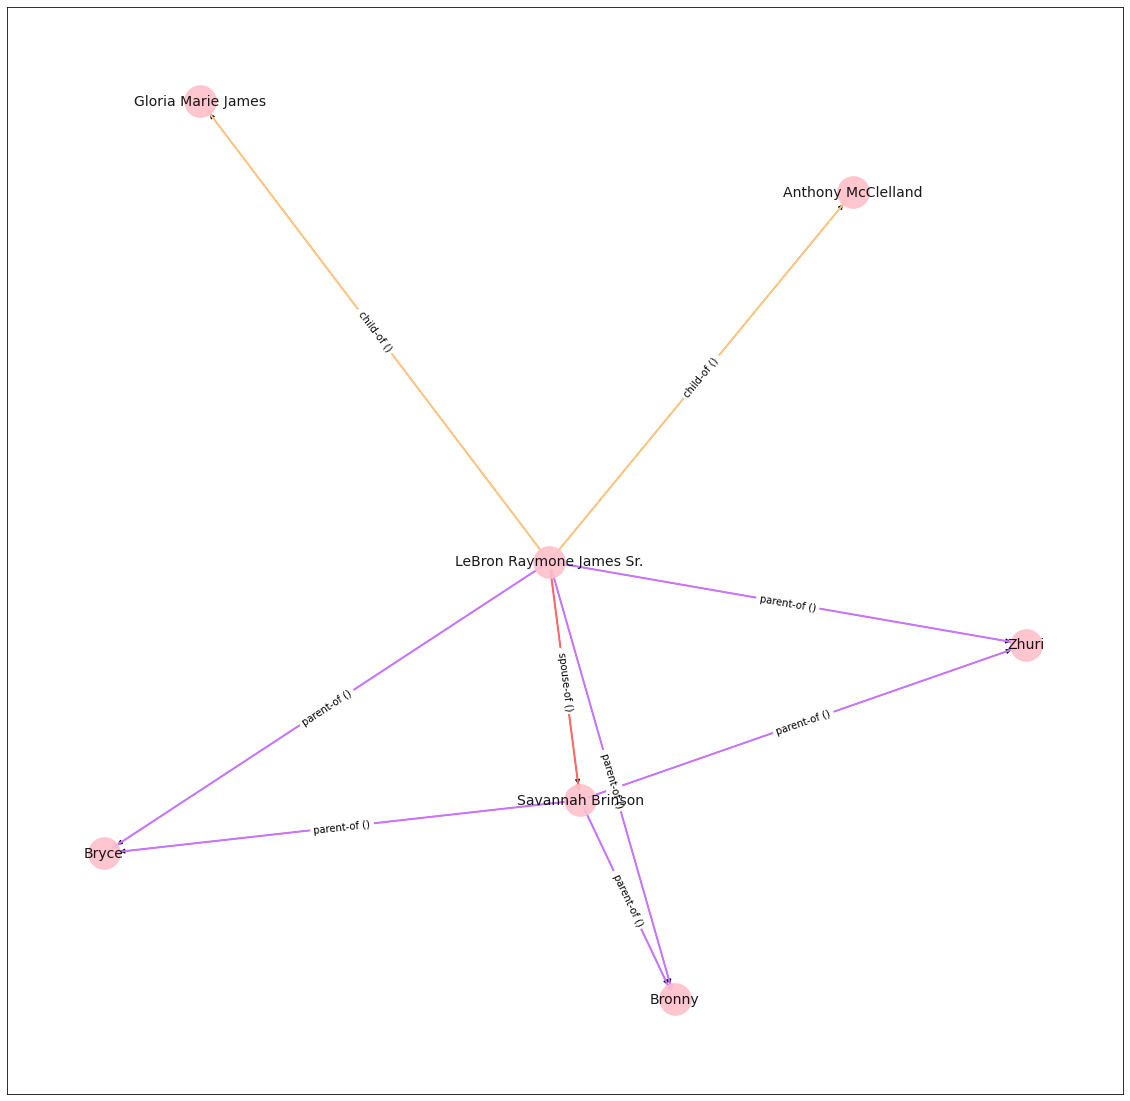

In [258]:
graph = RelGraphBuilder(true_drs[9])
graph.draw_graph()

In [8]:
df = pd.read_pickle('model_dataset.pkl')

le = LabelEncoder()
le.fit(df['relationship'])
le.classes_
label2id = dict(zip(le.classes_, range(len(le.classes_))))
display(label2id)
id2label = {v: k for k, v in label2id.items()}
display(id2label)

{'child-of': 0, 'no-rel': 1, 'parent-of': 2, 'sibling-of': 3, 'spouse-of': 4}

{0: 'child-of', 1: 'no-rel', 2: 'parent-of', 3: 'sibling-of', 4: 'spouse-of'}

In [75]:
# my_model = BertForSequenceClassification.from_pretrained("./models")
# tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
# tokenizer.add_tokens(['[E1]', '[/E1]', '[E2]', '[/E2]'])

# my_model.config.id2label = id2label
# my_model.config.label2id = label2id

In [76]:
# my_model.resize_token_embeddings(None) #should be 29000

In [77]:
# from transformers import AutoModelForSequenceClassification
# model2 = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=4)

In [512]:
model2.resize_token_embeddings(None)

Embedding(28996, 768, padding_idx=0)

In [513]:
print(tokenizer.convert_ids_to_tokens(tokenizer.encode('He and his grandson Mark went to the beach for hospitalization.')))

['[CLS]', 'He', 'and', 'his', 'grandson', 'Mark', 'went', 'to', 'the', 'beach', 'for', 'hospital', '##ization', '.', '[SEP]']


In [514]:
from transformers import pipeline
model_pipeline = pipeline(task='text-classification',
                          model=my_model,
                          tokenizer=tokenizer)

In [520]:
e1 = Entity('John', 4, 5)
e1('hello')

TypeError: 'Entity' object is not callable

# Transforms

In [9]:
transforms = [
    (lambda e: f'[E1] {e} [/E1]', lambda e: f'[E2] {e} [/E2]'),
    (lambda e: f'[PERSON1]', lambda e: f'[PERSON2]'),
    (lambda e: f'[PERSON]', lambda e: f'[PERSON]'),
    (lambda e: f'[HEAD]', lambda e: f'[TAIL]'),
    (lambda e: f'[MASK]', lambda e: f'[MASK]'),
    (lambda e: f'[E1]', lambda e: f'[E2]')
]

# Wikipedia --> Label-Studio

In [10]:
# # files = [fn for fn in os.listdir('wiki_data') if fn[0] != '.']
# files = ['untitled7.txt']
# # relations = [DocRelations(f'wiki_data/{fn}', from_file=True, t_e1=transforms[0][0], t_e2=transforms[0][1], classifier_pipeline=model_pipeline) for fn in files]
# relations = [DocRelations(f'wiki_data/{fn}', from_file=True, skip_classifier=True) for fn in files]
# docs = [DataLoader.get_json_data(dr) for dr in relations]
# with open('predicted_labeled_data.json', 'w') as f:
#     json.dump(docs, f)
# # for i in range(len(os.listdir('wiki_data'))):


## Placeholder

In [498]:
texts = []
with open('exported.json', 'r') as f:
    ls_data = json.load(f)
    
ls_data = [d for d in ls_data]
    
for d in ls_data:
    texts.append(d['data']['text'])

true_drs = [DocRelations(d, from_labeled=True) for d in ls_data][::-1]
pred_drs = [DocRelations(t, skip_classifier=True, skip_cleaning=True) for t in tqdm(texts)][::-1]
# true_dr = DocRelations(ls_data[1], from_labeled=True)
# pred_dr = DocRelations(texts[1], skip_classifier=True)
# output = [DataLoader.get_json_data(dr) for dr in ls_drs]

# with open('LABEL_TO_LABEL.json', 'w') as f:
#     json.dump(output, f)
# ls_drs = DocRelations(data[1], from_labeled=True)

100%|███████████████████████████████████████████████| 104/104 [00:58<00:00,  1.78it/s]


In [32]:
spacy_ents = [[Entity(e.text, e.start_char, e.end_char, ent_type='entity') for e in nlp(d.text).ents if e.label_ == 'PERSON'] for d in tqdm(pred_drs)]

100%|█████████████████████████████████████████████| 104/104 [00:58<00:00,  1.77it/s]


In [30]:
def eval_prec_rec_f1(true, pred):
    true = set(true)
    pred = set(pred)
    if len(pred) == 0:
        return {'precision' : 0, 'recall': 0, 'f1': 0}
    
    precision = len(pred.intersection(true)) / len(pred)
    recall = len(pred.intersection(true)) / len(true)
    true_positives = len(pred.intersection(true))
    false_positives = len(pred) - true_positives
    false_negatives = len(true) - true_positives

    if precision + recall == 0:
        f1 = 0
    else:   
        f1 = 2 * (precision * recall) / (precision + recall)

    return {
        'precision' : precision,
        'recall': recall,
        'f1' : f1,
        'tp' : true_positives,
        'fp' : false_positives,
        'fn' : false_negatives
    }

def avg_scores(scores):
    df = pd.DataFrame(scores)
    sums = df.sum(axis=0)
    micro_p = sums['tp'] / (sums['tp'] + sums['fp'])
    micro_r = sums['tp'] / (sums['tp'] + sums['fn'])
    micro_f1 = 2 * (micro_p * micro_r) / (micro_p + micro_r)
    return {
        'macro_precision': df['precision'].mean(),
        'macro_recall': df['recall'].mean(),
        'macro_f1': df['f1'].mean(),
        'micro_precision': micro_p,
        'micro_recall': micro_r,
        'micro_f1': micro_f1,
    }

In [508]:
spacy_NER_ents = []
NER_ents = []
NER_all = []
coref_scores = []

for i in range(len(true_drs)):
    spacy_NER_ents.append(eval_prec_rec_f1(true_drs[i].get_entities(), spacy_ents[i]))
    NER_ents.append(eval_prec_rec_f1(true_drs[i].get_entities(), pred_drs[i].get_entities()))
    NER_all.append(eval_prec_rec_f1(true_drs[i].entities, pred_drs[i].entities))
    coref_scores.append(eval_prec_rec_f1(true_drs[i].get_coref_pairs(), pred_drs[i].get_coref_pairs()))

In [509]:
print('* Spacy NER alone for full-name entities')
display(avg_scores(spacy_NER_ents))
print('\n* NER with just entity names *')
display(avg_scores(NER_ents))
print('\n* NER with entity names and their anaphors *')
display(avg_scores(NER_all))
print('\n* Coreference resolution with only fully resolved entities and their mentions *')
display(avg_scores(coref_scores))

* Spacy NER alone for full-name entities


{'macro_precision': 0.9236673989923359,
 'macro_recall': 0.7720185720021259,
 'macro_f1': 0.8333981013249552,
 'micro_precision': 0.9209876543209876,
 'micro_recall': 0.7754677754677755,
 'micro_f1': 0.8419864559819412}


* NER with just entity names *


{'macro_precision': 0.9412669869044237,
 'macro_recall': 0.7853141979448105,
 'macro_f1': 0.8484724540098044,
 'micro_precision': 0.9382716049382716,
 'micro_recall': 0.7900207900207901,
 'micro_f1': 0.8577878103837472}


* NER with entity names and their anaphors *


{'macro_precision': 0.9548344884215538,
 'macro_recall': 0.8033276730062396,
 'macro_f1': 0.8617436192210861,
 'micro_precision': 0.9527938342967245,
 'micro_recall': 0.8169052863436124,
 'micro_f1': 0.879632374740587}


* Coreference resolution with only fully resolved entities and their mentions *


{'macro_precision': 0.6521147422603277,
 'macro_recall': 0.5011973041447959,
 'macro_f1': 0.5539014085850289,
 'micro_precision': 0.6598605577689243,
 'micro_recall': 0.48129313476207775,
 'micro_f1': 0.5566057550934678}

In [ ]:
## FROM LABEL STUDIO TO LABEL STUDIO
with open('exported.json', 'r') as f:
    data = json.load(f)

ls_drs = [DocRelations(d, from_labeled=True) for d in data]
output = [DataLoader.get_pandas_data(dr, transforms, with_negatives=True) for dr in ls_drs]
df = pd.concat(output)

blah = df[df['type'] == 'n']
# blah.head(5)
print(ls_drs[0].entities)
print([e.ent_type for e in ls_drs[0].entities])

### Convert no labels to corefs

In [34]:
with open('exported.json') as f:
    data = json.load(f)

for d in data:
    for ann in d['annotations'][0]['result']:
        if ann['type'] == 'relation':
            if ann['labels'] == []:
                ann['labels'] = ['coref']
                    
with open('new_labels.json', 'w') as f:
    json.dump(data[::-1], f)

In [ ]:
with open('half-done.json') as f:
    data = json.load(f)
    
corefs = {}
for d in data:
    doc_id = d['id']
    corefs[doc_id] = {}
    for ann in d['annotations'][0]['result']:
        if ann['type'] == 'labels':
            corefs[doc_id][ann['id']] = Entity(ann['value']['text'], ann['value']['start'], ann['value']['end'])
            

def new_label():
    a = input().strip()
    while a != 'c' and a != 'p':
        print('try again...')
        a = input().strip()
    if a == 'c':
        return 'child-of'
    elif a == 'p':
        return 'parent-of'
            
# display(corefs)
for d in data:
    coref_dict = corefs[d['id']]
    for ann in d['annotations'][0]['result']:
        if ann['type'] == 'relation':
            if len(ann['labels']) > 1:
                e1 = coref_dict[ann['from_id']]
                e2 = coref_dict[ann['to_id']]
                if e1.start < e2.start:
                    print(f'** FORWARD {e1.text} --> {e2.text} **')
                    start = e1.start - 15 if e1.start-15 >= 0 else 0
                    display(d['data']['text'][start : e2.end + 15])
                    ann['labels'] = [new_label()]
                elif e2.start < e1.start:
                    print(f'** BACKWARD {e1.text} <-- {e2.text} **')
                    start = e2.start - 15 if e2.start-15 >= 0 else 0
                    display(d['data']['text'][start : e2.end + 15])
                    ann['labels'] = [new_label()]
                    
with open('just_testing.json', 'w') as f:
    json.dump(data[::-1], f)

In [ ]:
with open('project-1-at-2022-04-28-19-40-df5bb584(UPDATED).json', 'r') as f:
    data_orig = json.load(f)
    
with open('LABEL_TO_LABEL.json', 'r') as f:
    data_2add = json.load(f)

In [667]:
combined = data_orig[::-1] + data_2add[17:]
combined.insert(5, data_2add[5])
combined[15]

with open('project-1-at-2022-04-28-19-40-df5bb584(UPDATED).json', 'w') as f:
    json.dump(combined, f)

In [546]:
item = blah.iloc[30]
spanss = item.relative_entity_spans
print('base_text:', item.base_text)
print('annotated_text:', item.annotated_text_0)
print(item.base_text[spanss[0][0]:spanss[0][1]])
print(item.base_text[spanss[1][0]:spanss[1][1]])

base_text: hom they named Chelsea. In November 1980, Bill Clinton was defeated in his bid for re-ele
annotated_text: hom they named [E1] Chelsea [/E1]. In November 1980, Bill Clinton was defeated in [E2] his [/E2] bid for re-ele
Chelsea
his


## Placeholder 2

In [36]:
# ls_dr = DocRelations('exported.json')
with open('exported.json', 'r') as f:
    data = json.load(f)

ls_drs = [DocRelations(d, from_labeled=True) for d in data]
output = [DataLoader.get_pandas_data(dr, [], with_negatives=True) for dr in ls_drs]
df = pd.concat(output)

all_other = df[df['relationship'] != 'no-rel']
no_rel = df[df['relationship'] == 'no-rel']
# # max_label = bidirectional.groupby('relationship').count()['text'].max()
# # display(max_label)
no_rel = no_rel.sample(len(all_other) * 2)
# # no_rel = no_rel.sample(max_label)
final = pd.concat([all_other, no_rel]).reset_index().drop(['index'], axis=1)
# # display(bino_df)
display(final['relationship'].value_counts())

le = LabelEncoder()
final['numerical'] = le.fit_transform(final['relationship'])
display(final)

final.to_pickle('model_dataset.pkl')
final.to_json('model_dataset.json')

no-rel        1554
child-of       227
parent-of      205
spouse-of      178
sibling-of     167
Name: relationship, dtype: int64

,base_text,absolute_entity_spans,relative_entity_spans,relationship,doc_ID,numerical
0,ter of Maine.\n\nShenna Bellows was born on Ma...,"[(353, 367), (449, 463)]","[(15, 29), (111, 125)]",child-of,104,0
1,ter of Maine.\n\nShenna Bellows was born on Ma...,"[(353, 367), (482, 495)]","[(15, 29), (144, 157)]",child-of,104,0
2,"ows lives with her husband, Brandon Baldwin, i...","[(1266, 1269), (1279, 1294)]","[(15, 18), (28, 43)]",spouse-of,104,4
3,", Costa Rica.\n\nBellows lives with her husban...","[(1247, 1254), (1279, 1294)]","[(15, 22), (47, 62)]",spouse-of,104,4
4,"ewish parents. Her father, Mitchell ""Mitch"" Wi...","[(313, 316), (325, 351)]","[(15, 18), (27, 53)]",child-of,103,0
...,...,...,...,...,...,...
2326,"er, nicknamed ""Big Jesse"", served as both fire...","[(79, 88), (138, 141)]","[(15, 24), (74, 77)]",no-rel,12,1
2327,and eventually he sold it for $17.2 million to...,"[(2425, 2427), (2457, 2471)]","[(15, 17), (47, 61)]",no-rel,25,1
2328,is the son of William H. Gates Sr. and Mary M...,"[(566, 586), (591, 609)]","[(15, 35), (40, 58)]",no-rel,22,1
2329,r of the House Paul Ryan. The couple has two d...,"[(1357, 1366), (1398, 1403)]","[(15, 24), (56, 61)]",no-rel,98,1


### No negative samples

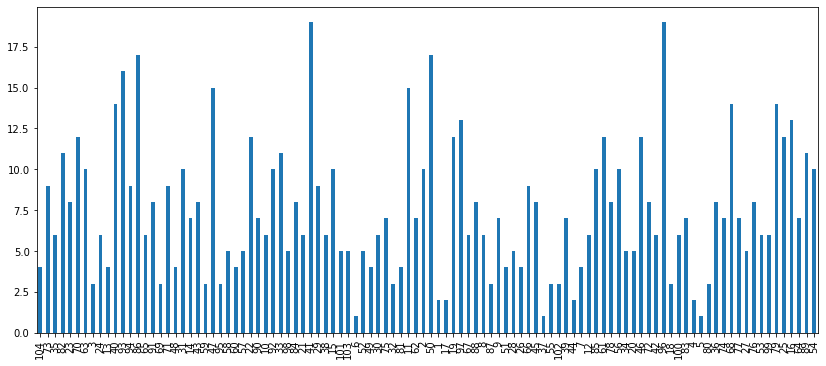

In [44]:
others = final[final['relationship'] != 'no-rel']
doc_rels = others['doc_ID'].value_counts()
doc_rels.sample(frac=1, random_state=73).plot.bar(figsize=(14,6))

In [45]:
lengths = []
def get_length(row):
    return abs(row[0][0] - row[1][1])
lengths = others['absolute_entity_spans'].apply(get_length).sort_values(ascending=False)
lengths

664    189
273    173
423    172
336    169
137    159
      ... 
501     13
655     12
534     12
637      6
455      2
Name: absolute_entity_spans, Length: 777, dtype: int64

In [66]:
lengths.tail(int(len(lengths) * 0.99))

272    155
244    154
507    154
262    152
95     150
      ... 
501     13
655     12
534     12
637      6
455      2
Name: absolute_entity_spans, Length: 769, dtype: int64

# Labeled data --> Colab DFs

In [282]:
EDGE_CHARS = 45

with open('exported.json', 'r') as f:
    data = json.load(f)

ls_drs = [DocRelations(d, from_labeled=True) for d in data]
output = [DataLoader.get_pandas_data(dr, [], edge_chars=EDGE_CHARS, with_negatives=True) for dr in ls_drs]
df = pd.concat(output)

all_other = df[df['relationship'] != 'no-rel']
no_rel = df[df['relationship'] == 'no-rel']
no_rel = no_rel.sample(len(all_other) * 2, random_state=SEED)
final = pd.concat([all_other, no_rel]).reset_index().drop(['index'], axis=1)
display(final['relationship'].value_counts())

le = LabelEncoder()
final['numerical'] = le.fit_transform(final['relationship'])
display(final)

# final.to_pickle(f'model_dataset_edge_chars_{EDGE_CHARS}.pkl')
# final.to_json('model_dataset_15_edge.json')

no-rel        1554
child-of       227
parent-of      205
spouse-of      178
sibling-of     167
Name: relationship, dtype: int64

,base_text,absolute_entity_spans,relative_entity_spans,relationship,doc_ID,numerical
0,Holocaust and Human Rights Center of Maine.\n\...,"[(353, 367), (449, 463)]","[(45, 59), (141, 155)]",child-of,104,0
1,Holocaust and Human Rights Center of Maine.\n\...,"[(353, 367), (482, 495)]","[(45, 59), (174, 187)]",child-of,104,0
2,"in San Jose, Costa Rica.\n\nBellows lives with...","[(1266, 1269), (1279, 1294)]","[(45, 48), (58, 73)]",spouse-of,104,4
3,"n exchange student in San Jose, Costa Rica.\n\...","[(1247, 1254), (1279, 1294)]","[(45, 52), (77, 92)]",spouse-of,104,4
4,"in Gordon Hill, Enfield, to Jewish parents. H...","[(313, 316), (325, 351)]","[(45, 48), (57, 83)]",child-of,103,0
...,...,...,...,...,...,...
2326,"parents to send her to her father's sister, G...","[(433, 439), (519, 522)]","[(45, 51), (131, 134)]",no-rel,29,1
2327,"school, Helms was voted ""Most Obnoxious"" in h...","[(1889, 1892), (1911, 1916)]","[(45, 48), (67, 72)]",no-rel,12,1
2328,"Voorhies was ""a natural-born ham."" However, h...","[(706, 709), (743, 746)]","[(45, 48), (82, 85)]",no-rel,26,1
2329,"in Camelot, with McGuire as King Arthur and C...","[(213, 219), (241, 245)]","[(45, 51), (73, 77)]",no-rel,1,1


In [19]:
le.classes_
label2id = dict(zip(le.classes_, range(len(le.classes_))))
display(label2id)
id2label = {v: k for k, v in label2id.items()}
display(id2label)

{'child-of': 0, 'no-rel': 1, 'parent-of': 2, 'sibling-of': 3, 'spouse-of': 4}

{0: 'child-of', 1: 'no-rel', 2: 'parent-of', 3: 'sibling-of', 4: 'spouse-of'}

In [220]:
transforms = [
    (lambda e: f'[E1] {e} [/E1]', lambda e: f'[E2] {e} [/E2]'),
    (lambda e: f'[PERSON1]', lambda e: f'[PERSON2]')
]
df = DataLoader.get_pandas_data(dr, transforms, with_negatives=True)
df

,base_text,e1_start,e1_end,e2_start,e2_end,relationship,type,doc_ID,annotated_text_0,annotated_text_1
0,Chan was born on 7 April 1954 in Hong Kong as ...,0,4,64,71,parent-child,bidirectional,99,[E1] Chan [/E1] was born on 7 April 1954 in Ho...,[PERSON1] was born on 7 April 1954 in Hong Kon...
1,Chan was born on 7 April 1954 in Hong Kong as ...,0,4,76,88,parent-child,bidirectional,99,[E1] Chan [/E1] was born on 7 April 1954 in Ho...,[PERSON1] was born on 7 April 1954 in Hong Kon...
2,ay the doctor. His parents nicknamed him Pao-p...,209,212,231,234,siblings,bidirectional,99,ay the doctor. [E1] His [/E1] parents nickname...,ay the doctor. [PERSON1] parents nicknamed [PE...
3,"ict.\n\nIn 1982, Chan married Joan Lin, a Taiw...",478,482,491,499,marriage,bidirectional,99,"ict.\n\nIn 1982, [E1] Chan [/E1] married [E2] ...","ict.\n\nIn 1982, [PERSON1] married [PERSON2], ..."
4,", Chan married Joan Lin, a Taiwanese actress. ...",491,499,550,561,parent-child,bidirectional,99,", Chan married [E1] Joan Lin [/E1], a Taiwanes...",", Chan married [PERSON1], a Taiwanese actress...."
5,hat same year. Chan's extra-marital affair wit...,588,592,621,637,marriage,bidirectional,99,hat same year. [E1] Chan [/E1]'s extra-marital...,hat same year. [PERSON1]'s extra-marital affai...
6,hat same year. Chan's extra-marital affair wit...,588,592,673,689,parent-child,bidirectional,99,hat same year. [E1] Chan [/E1]'s extra-marital...,hat same year. [PERSON1]'s extra-marital affai...
7,al affair with Elaine Ng Yi-Lei produced a dau...,621,637,673,689,parent-child,bidirectional,99,al affair with [E1] Elaine Ng Yi-Lei [/E1] pro...,al affair with [PERSON1] produced a daughter b...
8,"the results of the affair, Chan said he had ""o",1001,1011,1013,1017,marriage,bidirectional,99,"the results of [E1] the affair [/E1], [E2] Cha...","the results of [PERSON1], [PERSON2] said he ha..."
9,"the results of the affair, Chan said he had ""o...",1001,1011,1023,1025,marriage,bidirectional,99,"the results of [E1] the affair [/E1], Chan sai...","the results of [PERSON1], Chan said [PERSON2] ..."


In [221]:
df['relationship'].value_counts()

marriage        8
no-rel          7
parent-child    5
siblings        1
Name: relationship, dtype: int64

In [223]:
df.iloc[19].annotated_text_0

'each month for [E1] her [/E1] living expenses and 600,000 HK dollars when she moved to Shanghai, the transactions were later claimed to be nonexistent by [E2] her [/E2] lawyer. Despit'

In [416]:
test = DocRelations('wiki_data/untitled.txt', from_file=True, classifier_pipeline=model_pipeline)

Using values:
max_span_len=140
edge_chars=15


/Users/angelloparr/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:108: UserWarning: One or both transformation functions for entities are not defined... using default... [E#] x [/E#]


In [419]:
transforms = [
    (lambda e: f'[E1] {e} [/E1]', lambda e: f'[E2] {e} [/E2]'),
    (lambda e: f'[PERSON1]', lambda e: f'[PERSON2]')
]
df = DataLoader.get_pandas_data(test, transforms, with_negatives=True)
df

AttributeError: 'DocRelations' object has no attribute 'doc_ID'

In [398]:
files = [fn for fn in os.listdir('wiki_data') if fn[0] != '.']
docs = [DocRelations(f'wiki_data/{fn}', from_file=True, classifier_pipeline=model_pipeline) for fn in files]
docs = [DataLoader.get_json_data(dr) for dr in docs]
with open('predicted_labeled_data.json', 'w') as f:
    json.dump(docs, f)
# for i in range(len(os.listdir('wiki_data'))):


Using values:
max_span_len=140
edge_chars=15


/Users/angelloparr/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:108: UserWarning: One or both transformation functions for entities are not defined... using default... [E#] x [/E#]


Using values:
max_span_len=140
edge_chars=15


Load up documents from Label Studio into data-rich classes

In [ ]:
ls_dr = DocRelations('exported.json')
# with open('exported.json', 'r') as f:
#     data = json.load(f)

TypeError: list indices must be integers or slices, not str

In [167]:
# text = "Kimberly Noel Kardashian was born on October 21, 1980, in Los Angeles, California, to Robert and Kris Kardashian . She has an older sister, Kourtney, a younger sister, Khloé, and a younger brother, Rob. Their mother is of Dutch, English, Irish, and Scottish ancestry, while their father was a third-generation Armenian-American. After their parents divorced in 1991, her mother married again that year, to Bruce Jenner, the 1976 Summer Olympics decathlon winner. Through their marriage, Kim Kardashian gained step-brothers Burton \"Burt\", Brandon, and Brody; step-sister Casey; and half-sisters Kendall and Kylie Jenner."
# print(text)
# yz = nlp(text)
# sents = [s for s in yz.sents]

In [385]:
test = DocRelations(data[1], with_negatives=True)

In [386]:
print(test.text)
test.get_relationships()

Grace Brewster Murray was born in New York City. She was the eldest of three children. Her parents, Walter Fletcher Murray and Mary Campbell Van Horne, were of Scottish and Dutch descent, and attended West End Collegiate Church. Her great-grandfather, Alexander Wilson Russell, an admiral in the US Navy, fought in the Battle of Mobile Bay during the Civil War.

In 1930 Grace Murray married New York University professor Vincent Foster Hopper; they divorced in 1945. Although she did not marry again, she retained his surname.


[[parent-child] Her (Tj1) <---> Walter Fletcher Murray (wX-),
 [daughter-of] Her (Tj1) ---> Walter Fletcher Murray (wX-),
 [parent-child] Her (Tj1) <---> Mary Campbell Van Horne (etN),
 [daughter-of] Her (Tj1) ---> Mary Campbell Van Horne (etN),
 [no-rel] Her (Tj1) ---> Vincent Foster Hopper (flf),
 [father-of] Walter Fletcher Murray (wX-) ---> Her (Tj1),
 [mother-of] Mary Campbell Van Horne (etN) ---> Her (Tj1),
 [no-rel] Mary Campbell Van Horne (etN) ---> she (Blc),
 [marriage] Grace Murray (aDd) <---> Vincent Foster Hopper (flf),
 [wife-of] Grace Murray (aDd) ---> Vincent Foster Hopper (flf),
 [no-rel] Grace Murray (aDd) ---> she (2fw),
 [husband-of] Vincent Foster Hopper (flf) ---> Grace Murray (aDd),
 [no-rel] Vincent Foster Hopper (flf) ---> she (Blc),
 [no-rel] Grace Brewster Murray (W-k) ---> she (Blc),
 [no-rel] Grace Brewster Murray (W-k) ---> She (Iw0),
 [no-rel] Grace Brewster Murray (W-k) ---> Vincent Foster Hopper (flf),
 [no-rel] Her (TF2) ---> she (2fw),
 [no-rel] Her (

Convert data from DocRelations to DataFrames for use in transformer training
This is necessary because for different models, DataFrames of varying structure will be needed

In [171]:
def get_bert_data(doc, transform_e1, transform_e2, boundary_chars):
    bert_data = {
        'text': [],
        'relationship': [],
        'type': [],
        'doc_ID': []
    }
    
    for rel in doc.get_relationships():
        bert_data['text'].append(rel.get_annotated_span(doc.text, transform_e1, transform_e2, boundary_chars))
        bert_data['relationship'].append(rel.label)
        bert_data['type'].append(rel.label_type)
        bert_data['doc_ID'].append(doc.doc_ID)
    
    return bert_data

def make_dataset(doc_json, transform_e1, transform_e2, boundary_chars):
    with open('exported.json', 'r') as f:
        docs = json.load(f)

    text = []
    relationships = []
    types = []
    doc_IDs = []
    
    for exported_data in docs:
        doc = DocRelations(exported_data, with_negatives=True)
        doc_data = get_bert_data(doc, transform_e1, transform_e2, boundary_chars)
        text = text + doc_data['text']
        relationships = relationships + doc_data['relationship']
        types = types + doc_data['type']
        doc_IDs = doc_IDs + doc_data['doc_ID']
    
    return pd.DataFrame({
        'text' : text,
        'relationship' : relationships,
        'type' : types,
        'doc_ID': doc_IDs
    })

In [172]:
t_e1 = lambda e: f'[E1] {e} [/E1]'
t_e2 = lambda e: f'[E2] {e} [/E2]'
# t_e1 = lambda e: f'[PERSON1]'
# t_e2 = lambda e: f'[PERSON2]'
boundary_chars = 15
df = make_dataset('exported.json', t_e1, t_e2, boundary_chars)
df

,text,relationship,type,doc_ID
0,"uary 27, 1980, [E1] Rodham [/E1] gave birth to...",parent-child,bidirectional,52
1,"uary 27, 1980, [E1] Rodham [/E1] gave birth to...",mother-of,f,52
2,"uary 27, 1980, [E2] Rodham [/E2] gave birth to...",daughter-of,b,52
3,daughter whom [E1] they [/E1] named Chelsea. ...,no-rel,n,52
4,daughter whom [E1] they [/E1] named Chelsea. ...,no-rel,n,52
...,...,...,...,...
986,was one. There [E1] Hermann [/E1] and [E2] his...,no-rel,n,4
987,was one. There [E2] Hermann [/E2] and his brot...,brother-of,b,4
988,re Hermann and [E2] his [/E2] brother [E1] Jak...,brother-of,b,4
989,re Hermann and [E1] his [/E1] brother [E2] Jak...,siblings,bidirectional,4


In [173]:
bidirectional = df[df['type'] == 'bidirectional']
no_rel = df[df['type'] == 'n']
max_label = bidirectional.groupby('relationship').count()['text'].max()
display(max_label)
no_rel = no_rel.sample(frac=len(bidirectional)/len(no_rel))
# no_rel = no_rel.sample(max_label)
bino_df = pd.concat([bidirectional, no_rel])
display(bino_df)
display(bino_df['relationship'].value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
bino_df['numerical'] = le.fit_transform(bino_df['relationship'])
bino_df

bino_df.to_json('model_dataset.json')

87

,text,relationship,type,doc_ID
0,"uary 27, 1980, [E1] Rodham [/E1] gave birth to...",parent-child,bidirectional,52
6,"of Park Ridge. [E1] Her [/E1] father, [E2] Hug...",parent-child,bidirectional,51
11,"e had founded. [E1] Her [/E1] mother, [E2] Dor...",parent-child,bidirectional,51
17,Welsh descent. [E1] She [/E1] had two younger ...,siblings,bidirectional,51
19,Welsh descent. [E1] She [/E1] had two younger ...,siblings,bidirectional,51
...,...,...,...,...
536,n Hong Kong as [E1] Chan Kong-sang [/E1] to [E...,no-rel,n,25
444,[E1] Milton Berle [/E1] was born into a Jewish...,no-rel,n,31
603,[E1] Rock [/E1] married Malaak Compton-Rock on...,no-rel,n,21
201,"re Carazo, and [E1] Roy Elwood Cohn [/E1], a U...",no-rel,n,44


no-rel          171
parent-child     87
siblings         42
marriage         42
Name: relationship, dtype: int64

In [174]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
bino_df['numerical'] = le.fit_transform(bino_df['relationship'])
bino_df

,text,relationship,type,doc_ID,numerical
0,"uary 27, 1980, [E1] Rodham [/E1] gave birth to...",parent-child,bidirectional,52,2
6,"of Park Ridge. [E1] Her [/E1] father, [E2] Hug...",parent-child,bidirectional,51,2
11,"e had founded. [E1] Her [/E1] mother, [E2] Dor...",parent-child,bidirectional,51,2
17,Welsh descent. [E1] She [/E1] had two younger ...,siblings,bidirectional,51,3
19,Welsh descent. [E1] She [/E1] had two younger ...,siblings,bidirectional,51,3
...,...,...,...,...,...
536,n Hong Kong as [E1] Chan Kong-sang [/E1] to [E...,no-rel,n,25,1
444,[E1] Milton Berle [/E1] was born into a Jewish...,no-rel,n,31,1
603,[E1] Rock [/E1] married Malaak Compton-Rock on...,no-rel,n,21,1
201,"re Carazo, and [E1] Roy Elwood Cohn [/E1], a U...",no-rel,n,44,1


In [175]:
bino_df.to_json('model_dataset.json')

In [176]:
bi_df = bino_df[bino_df['relationship'] != 'no-rel']
bi_df['text'].str.len().mean()

100.9298245614035

Generate entity rel data from text

In [177]:
MAX_SPAN_LEN = 140

class ParagraphPipeline:
    def __init__(self, paragraph, t_e1=lambda x: f'[E1] {x} [/E1]', t_e2=lambda x: f'[E2] {x} [/E2]', edge_chars=20):
        self.t_e1 = t_e1
        self.t_e2 = t_e2
        self.edge_chars = edge_chars
        self.text = clean_wikitext(paragraph)
        self.spacy_doc = nlp(self.text)
        self.entities = []
        self.rels = []
        ents = get_relevant_annotations(self.spacy_doc)
        
        for e in ents:
            self.entities.append(Entity(e.text, e.start_char, e.end_char))

        clust_pairs = get_cluster_pairs(self.spacy_doc)
        clust_dict = defaultdict(lambda: [])
        
        for refers2, coref in clust_pairs:
            refers2 = [Entity(r2.text, r2.start_char, r2.end_char) for r2 in refers2]
            for c in coref:
                c_ent = Entity(c.text, c.start_char, c.end_char)
                # print(type(refers2[0]))
                clust_dict[c_ent] = clust_dict[c_ent] + refers2
                    
        self.entity_rels = clust_dict

        for i in range(len(self.entities)):
            for j in range(i + 1, len(self.entities)):
                e1 = self.entities[i]
                e2 = self.entities[j]
                span = self.text[e1.start : e2.end]
                if len(span) < MAX_SPAN_LEN:
                    new_rel = Relation(e1, e2)
                    self.rels.append(new_rel)
                    
    def get_annotated_rels(self):
        return [rel.get_annotated_span(self.text, self.t_e1, self.t_e2, self.edge_chars) for rel in self.rels]

                    # print(new_rel.get_annotated_span(self.text, self.t_e1, self.t_e2, self.edge_chars))

In [292]:
class RelGraphBuilder:
    def __init__(self, par_info, pipeline):
        self.par_info = par_info
        self.pipeline = pipeline
        self.G = nx.Graph()
        self.e_labels = {}
        edges = defaultdict(lambda: {'label' : 'no-rel', 'score' : 0})
        
        annotated_rel_spans = []
        
        rels = self.par_info.get_annotated_rels()
        preds = self.pipeline(rels)
        # print(preds)
        
        for i in range(len(self.par_info.rels)):
            rel = self.par_info.rels[i]
            rel_pred = preds[i]
            if rel_pred['label'] != 'no-rel' and rel_pred['score'] > 0.35 and rel_pred['score'] > edges[(rel.e1, rel.e2)]['score']:
                edges[(rel.e1, rel.e2)] = rel_pred
                
        corefs = self.par_info.entity_rels
        for (e1, e2), e_info in edges.items():
            if e1 in corefs:
                new_e1 = corefs[e1]
            else:
                new_e1 = [e1]
            if e2 in corefs:
                new_e2 = corefs[e2]
            else:
                new_e2 = [e2]
                
            for e_i in new_e1:
                for e_j in new_e2:
                    self.e_labels[(e_i, e_j)] = e_info
        
    def draw_graph(self):
        to_del = []
        for ents, rel in self.e_labels.items():
            print(ents, rel)
            if ents[0] == ents[1]:
                to_del.append(ents)
            elif rel['label'] != 'no-rel':
                    self.G.add_edge(ents[0], ents[1])
                    
        for ents in to_del:
            del self.e_labels[ents]

        plt.figure(figsize=(20,20))
        pos = nx.spring_layout(self.G)
        nx.draw(
            self.G, pos, edge_color='black', width=1, linewidths=1,
            node_size=750, node_color='pink', alpha=0.9,
            labels={node : node.text for node in self.G.nodes()}
        )
        nx.draw_networkx_edge_labels(
            self.G, pos,
            edge_labels={ents : rel['label'] for ents, rel in self.e_labels.items()},
            font_color='red'
        )

        display(self.G)
        
        

Use trained transformer from Google Colab to make genealogical knowledge graph

In [286]:
le.classes_
label2id = dict(zip(le.classes_, range(len(le.classes_))))
display(label2id)
id2label = {v: k for k, v in label2id.items()}
display(id2label)

{'marriage': 0, 'no-rel': 1, 'parent-child': 2, 'siblings': 3}

{0: 'marriage', 1: 'no-rel', 2: 'parent-child', 3: 'siblings'}

In [287]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/thesis/models")
# pt_model = AutoModelForSequenceClassification.from_pretrained(model_name)
my_model = BertForSequenceClassification.from_pretrained("./models")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# my_model = BertForSequenceClassification.from_pretrained('https://drive.google.com/drive/folders/1AsAs_6LtlefBLtttNJFkJgH-nWnK2Zcv?usp=sharing')

# inputs = tokenizer("[e1] Mary [/e1] is the sister of [e2] Mark [/e2]", return_tensors="pt")
# labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
# outputs = my_model(**inputs, labels=labels)
my_model.config.id2label = id2label
my_model.config.label2id = label2id
my_model.config

BertConfig {
  "_name_or_path": "./models",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "marriage",
    "1": "no-rel",
    "2": "parent-child",
    "3": "siblings"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "marriage": 0,
    "no-rel": 1,
    "parent-child": 2,
    "siblings": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [288]:
from transformers import pipeline, AutoTokenizer
model_pipeline = pipeline(task='text-classification',
                          model=my_model,
                          tokenizer=tokenizer)

(Martha Stewart, Martha Stewart) {'label': 'marriage', 'score': 0.44816508889198303}
(Randall Jackson, Martha Stewart) {'label': 'parent-child', 'score': 0.6100723743438721}
(Bethany Stewart, Martha Stewart) {'label': 'parent-child', 'score': 0.5279693603515625}
(Martha Stewart, Joanna) {'label': 'siblings', 'score': 0.41063863039016724}
(Joanna, Jonathan) {'label': 'siblings', 'score': 0.5393358469009399}
(Joanna, Martha Stewart) {'label': 'siblings', 'score': 0.6540481448173523}
(Jonathan, Martha Stewart) {'label': 'siblings', 'score': 0.471127450466156}
(Ghassan, Martha Stewart) {'label': 'marriage', 'score': 0.4729803800582886}
(Alexander Dekhtyar, Foaad Khosmood) {'label': 'marriage', 'score': 0.41407376527786255}


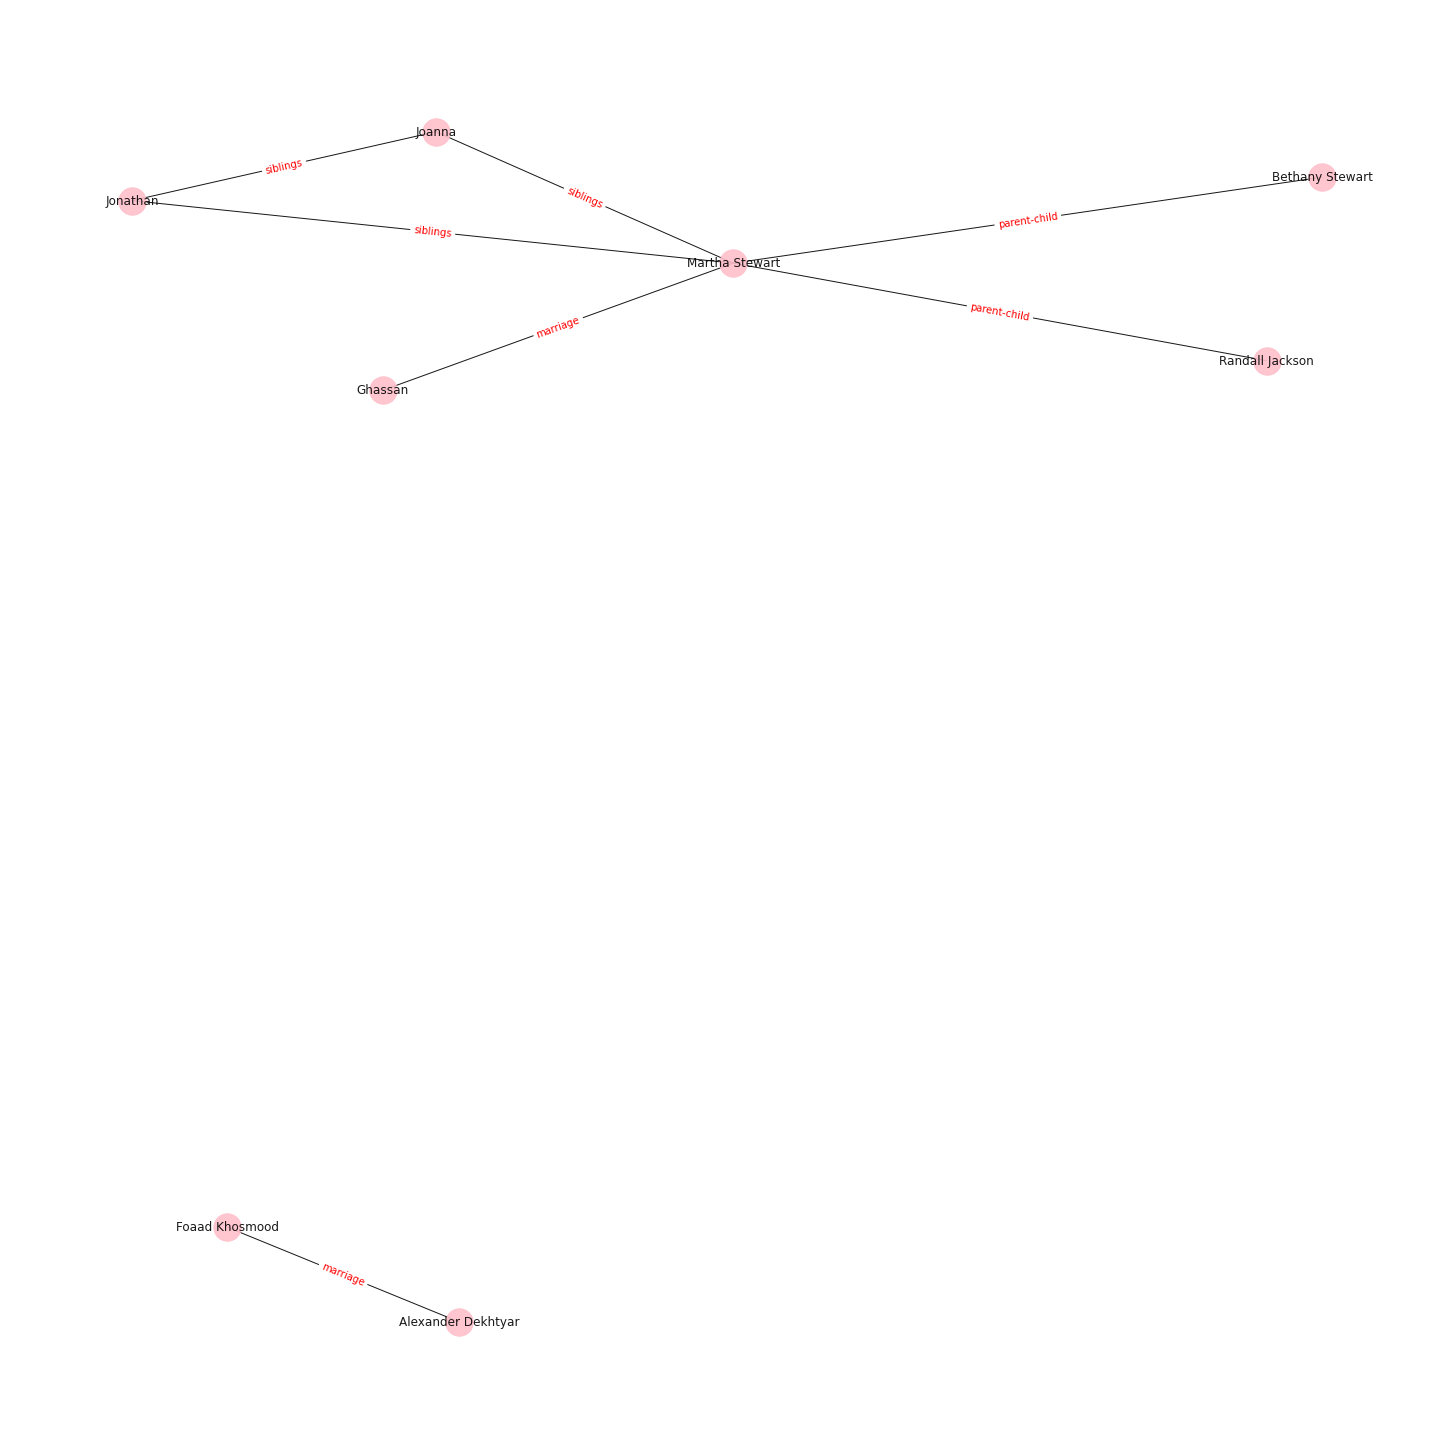

In [301]:
test_paragraph = '''
Guth was born on October 15, 1871, in Nashville, Tennessee, to Rev. George Guth and Susan Sophie Grandlienard of Perrefitte, Switzerland. Guth was of German, French, and Swiss descent.[1] When he was a teenager, his family moved to San Francisco, California. He enrolled at the University of the Pacific and continued his studies at the then-newly established Stanford University, from which he graduated Phi Beta Kappa in 1892.

Following his college graduation, he studied at University of California, Hastings College of the Law and was admitted to the California bar in December 1895. He practiced law in California for several years and then continued his studies at Boston University, earning a Bachelor of Sacred Theology and becoming ordained as a Methodist minister. He briefly served as a pastor before entering academia. Guth married Helen Louise Fischbeck of San Francisco in March 1896. In 1904, he received a doctorate from Halle University in Halle, Germany.[2] Guth's dissertation was titled Die ältere Schicht in den Erzählung über Saul und David.[3]
'''

test_paragraph = '''
Martha Stewart lived in Detroit all of her life when she emigrated from Peru in South America. She has a father named Randall Jackson and a mother named Bethany Stewart. Martha enjoys playing soccer with her sister Joanna and brother Jonathan. The three of them play kickball. Her best friend is Ghassan, although his brother hates Martha so he tries to get him to play with other friends from school, namely Alexander Dekhtyar and Foaad Khosmood.
'''

test = ParagraphPipeline(test_paragraph)
GG = RelGraphBuilder(test, model_pipeline)
GG.draw_graph()

In [279]:
paragraph1 = '''
Kimberly Noel Kardashian was born on October 21, 1980, in Los Angeles, California, to Robert and Kris Kardashian (née Houghton).[18] She has an older sister, Kourtney, a younger sister, Khloé, and a younger brother, Rob.[19] Their mother is of Dutch, English, Irish, and Scottish ancestry,[20] while their father was a third-generation Armenian-American.[21] After their parents divorced in 1991, her mother married again that year, to Bruce Jenner,[a] the 1976 Summer Olympics decathlon winner.[23] Through their marriage, Kim Kardashian gained step-brothers Burton "Burt", Brandon, and Brody; step-sister Casey; and half-sisters Kendall and Kylie Jenner.[24]
'''

paragraph2 = '''
Bryant was born in Philadelphia,[12] the youngest of three children and the only son of Pamela Cox Bryant and former NBA player Joe Bryant. He was also the maternal nephew of NBA player John "Chubby" Cox.[13] His parents named him after the famous beef of Kobe, Japan, which they saw on a restaurant menu.[14][15] His middle name, Bean, was derived from his father's nickname "Jellybean."[16] Bryant's family was Catholic and he was brought up with this faith.[17][18][19]

Bryant was the youngest of three children. He grew up with two older sisters, Sharia and Shaya, and had a close relationship with them until his death.

The Bryants' first daughter, Natalia, was born in January 2003.[409] The birth resulted in a reconciliation between Bryant and his parents. Due to an ectopic pregnancy, Vanessa suffered a miscarriage in the spring of 2005. Their second daughter, Gianna Maria-Onore (also referred to as "Gigi"), was born in May 2006.[410] On December 16, 2011, Vanessa Bryant filed for divorce, citing irreconcilable differences, and the couple requested joint custody of their daughters.[411][412] On January 11, 2013, Bryant and his wife both announced via social media that they had called off their divorce.[413] In early December 2016, Vanessa gave birth to their third daughter,[414][415][416] and in January 2019 the Bryants announced they were expecting a fourth daughter.[417] Their daughter was born in June 2019.[418][419]
'''

paragraph3 = '''
Walter Bruce Willis[4] was born in Idar-Oberstein, West Germany, on March 19, 1955.[5][6] His mother, Marlene,[7] was German, from Kassel.[5] His father, David Willis, was an American soldier. Willis has a younger sister, Florence, and two younger brothers, Robert (deceased) and David.[8] After being discharged from the military in 1957, his father relocated the family to his hometown of Carneys Point, New Jersey.[9] Willis has described his background as a "long line of blue-collar people".[9] His mother worked in a bank and his father was a welder, master mechanic, and factory worker.[4]
'''

paragraph4 = '''
Maria "Maja" Einstein (18 November 1881 – 25 June 1951) and her older brother, Albert, were the two children of Hermann Einstein and Pauline Einstein (née Koch), who had moved from Ulm to Munich in June 1881, when Albert was one.[14] There Hermann and his brother Jakob had founded Einstein & Cie., an electrical engineering company.[15]
'''

paragraph5 = '''
Bolt was born on 21 August 1986 to parents Wellesley and Jennifer Bolt[10] in Sherwood Content,[17] a small town in Jamaica. He has a brother, Sadiki,[18] and a sister, Sherine.[19][20] His parents ran the local grocery store in the rural area, and Bolt spent his time playing cricket and football in the street with his brother,[21] later saying, "When I was young, I didn't really think about anything other than sports."[22] As a child, Bolt attended Waldensia Primary, where he began showing his sprint potential when he ran in his parish's annual national primary school meet.[1] By the age of twelve, Bolt had become the school's fastest runner over the 100 metres distance.[23] Bolt also developed an affection for European football teams Real Madrid and Manchester United.[15]
'''

paragraph6 = '''
Ashley Michelle Tisdale was born on July 2, 1985 in Monmouth County, New Jersey to Lisa Morris and contractor Michael Tisdale.[2] Her father is Christian and her mother is Jewish; she was raised with "a little bit of both" religions.[3] Tisdale's elder sister Jennifer is an actress and producer.[4] She is also related to businessman Ron Popeil through her maternal grandfather Arnold Morris who was best known for being a pitchman for the Ginsu knife.[2][5] At the age of three, Tisdale met her manager, Bill Perlman, at a New Jersey mall. He sent her to various auditions for commercials, and she was placed in more than one hundred national network TV advertisements as a child.[6] She began her theatrical career by appearing in Gypsy: A Musical Fable and The Sound of Music at Monmouth County's Jewish Community Center.[7]
'''

# paragraph1 = clean_wikitext(paragraph1)
# paragraph2 = clean_wikitext(paragraph2)
# paragraph3 = clean_wikitext(paragraph3)
# paragraph4 = clean_wikitext(paragraph4)
# paragraph5 = clean_wikitext(paragraph5)
# paragraph6 = clean_wikitext(paragraph6)
test_par = '''
Heather Joy Knight was born in Jamaica and lived there for the first nine years of her life.[2] She immigrated to the United States, settling in the Bronx, New York, with her parents Austin and Herolin Evelyn.[2] Knight is married to professor and outreach chaplain, Norman Knight.[3] They have five sons and three daughters.[3]
'''

test = ParagraphPipeline(test_par)
display(test.entity_rels)
GG = RelGraphBuilder(test, model_pipeline)

defaultdict(<function __main__.ParagraphPipeline.__init__.<locals>.<lambda>()>,
            {her: [Heather Joy Knight],
             She: [Heather Joy Knight],
             her: [Heather Joy Knight],
             Knight: [Heather Joy Knight],
             They: [Norman Knight]})

defaultdict(<function __main__.RelGraphBuilder.__init__.<locals>.<lambda>()>,
            {(Herolin Evelyn, Knight): {'label': 'marriage',
              'score': 0.6283432245254517},
             (Herolin Evelyn, her): {'label': 'parent-child',
              'score': 0.8642414808273315},
             (Norman Knight, They): {'label': 'parent-child',
              'score': 0.7986356616020203}})

(Herolin Evelyn, Heather Joy Knight) {'label': 'parent-child', 'score': 0.8642414808273315}
(Norman Knight, Norman Knight) {'label': 'parent-child', 'score': 0.7986356616020203}


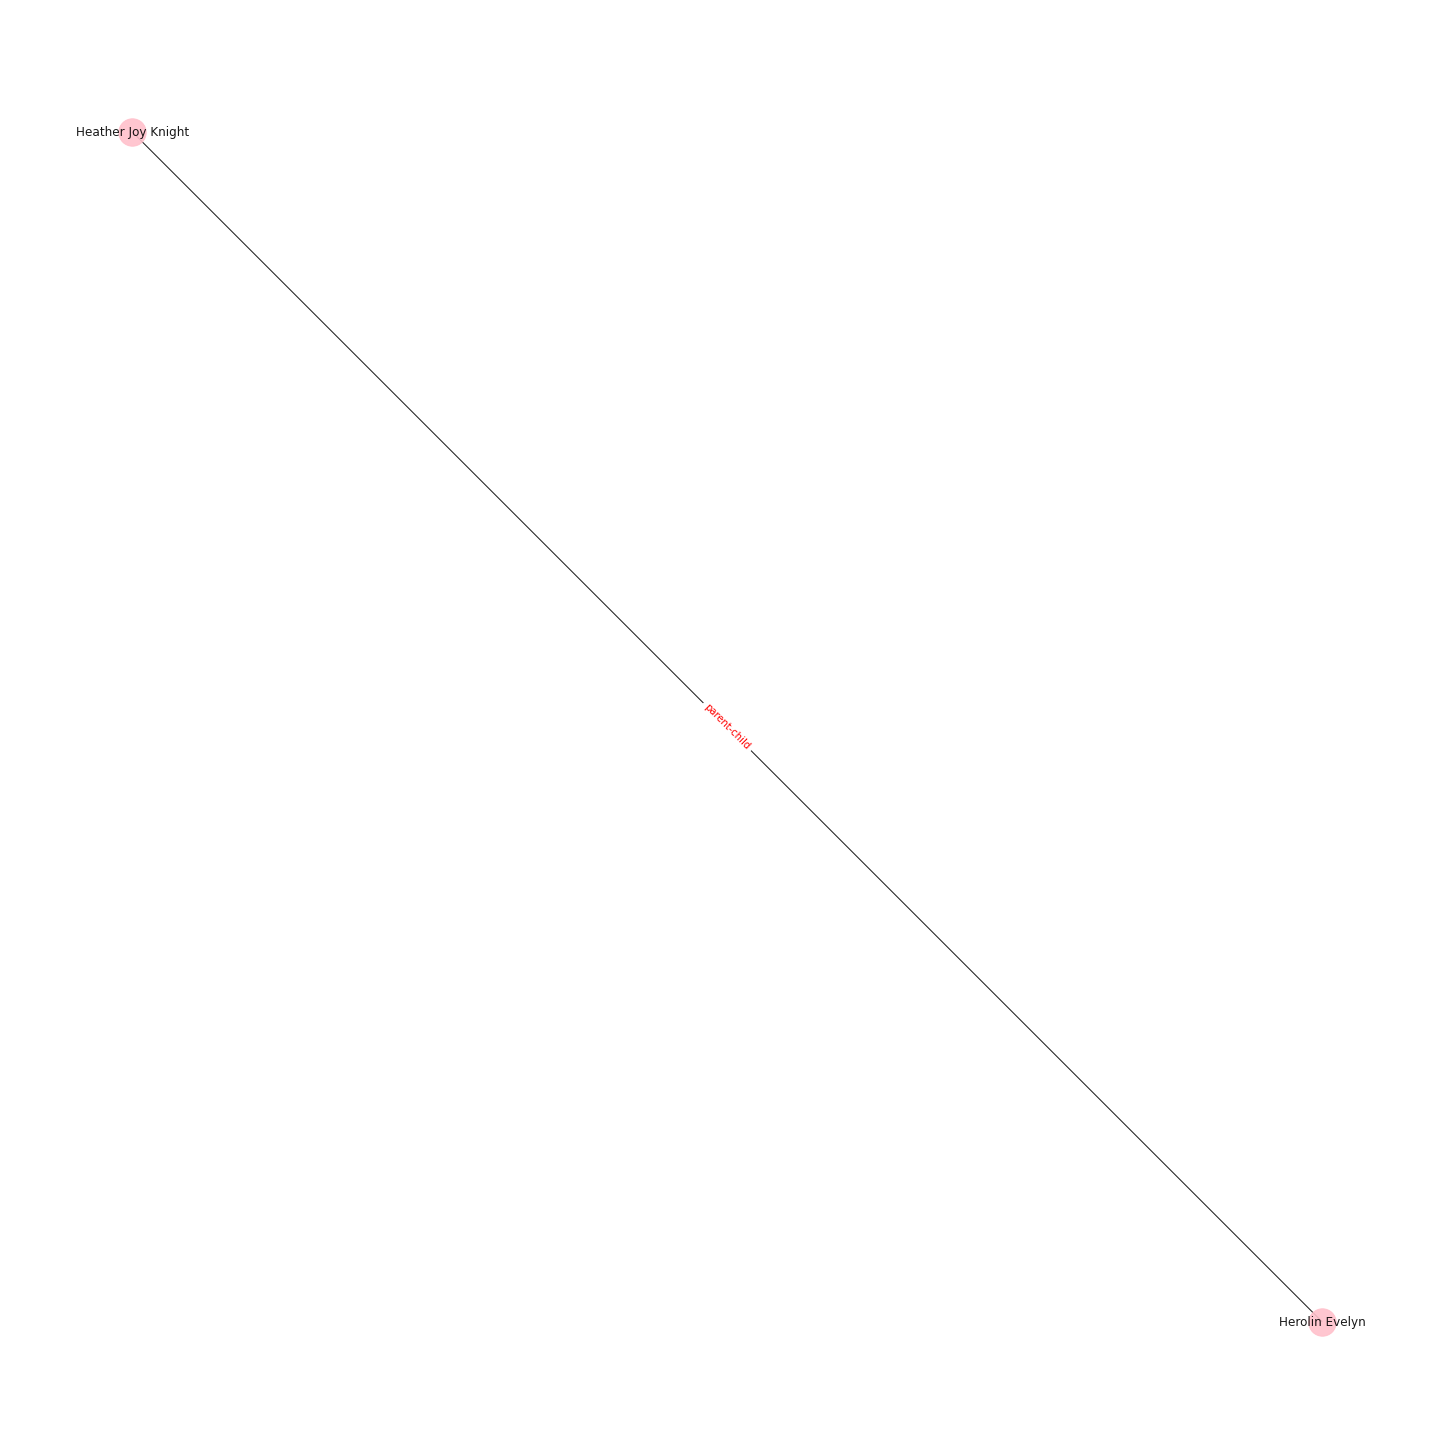

In [280]:
GG.draw_graph()

In [236]:
test.rels

[[N/A] Pamela Cox Bryant ---> Joe Bryant,
 [N/A] Pamela Cox Bryant ---> John "Chubby" Cox,
 [N/A] Joe Bryant ---> John "Chubby" Cox,
 [N/A] Bryant ---> he,
 [N/A] Shaya ---> Natalia,
 [N/A] Shaya ---> he,
 [N/A] Natalia ---> Bryant,
 [N/A] Natalia ---> he,
 [N/A] Bryant ---> Vanessa,
 [N/A] Bryant ---> he,
 [N/A] Vanessa ---> Gianna Maria-Onore,
 [N/A] Vanessa ---> he,
 [N/A] Gianna Maria-Onore ---> Vanessa Bryant,
 [N/A] Gianna Maria-Onore ---> he,
 [N/A] Vanessa Bryant ---> he,
 [N/A] Vanessa ---> he]

In [237]:
GG.e_labels

{(Pamela Cox Bryant, Pamela Cox Bryant): {'label': 'parent-child',
  'score': 0.4845684766769409}}

In [ ]:
list(GG.e_labels.keys())

In [ ]:
test.entity_rels

In [194]:
display(list(GG.e_labels.items()))

[((Maria "Maja" Einstein, Albert),
  {'label': 'parent-child', 'score': 0.7581347823143005}),
 ((Maria "Maja" Einstein, Hermann Einstein),
  {'label': 'parent-child', 'score': 0.9373174905776978}),
 ((Maria "Maja" Einstein, Pauline Einstein),
  {'label': 'parent-child', 'score': 0.8959909677505493}),
 ((Albert, Hermann Einstein),
  {'label': 'parent-child', 'score': 0.9302458167076111}),
 ((Albert, Pauline Einstein),
  {'label': 'parent-child', 'score': 0.9121272563934326}),
 ((Hermann Einstein, Pauline Einstein),
  {'label': 'parent-child', 'score': 0.8612006306648254}),
 ((Albert, Hermann), {'label': 'parent-child', 'score': 0.3581365942955017}),
 ((Hermann, Jakob), {'label': 'siblings', 'score': 0.5889827609062195}),
 ((Hermann, Hermann), {'label': 'siblings', 'score': 0.5581938624382019}),
 ((Jakob, Hermann), {'label': 'siblings', 'score': 0.5736629962921143})]

In [190]:
# for ents, rel in GG.e_labels.items():
#         if rel['label'] != 'no-rel':
#                 GG.G.add_edge(ents[0], ents[1])

# # list(GG.G.nodes())[0] == list(GG.G.nodes())[5]

In [73]:
{node: node.text for node in GG.G.nodes()}

{Marlene: 'Marlene',
 His: 'His',
 David Willis: 'David Willis',
 Robert: 'Robert',
 His: 'His',
 Willis: 'Willis',
 David: 'David'}

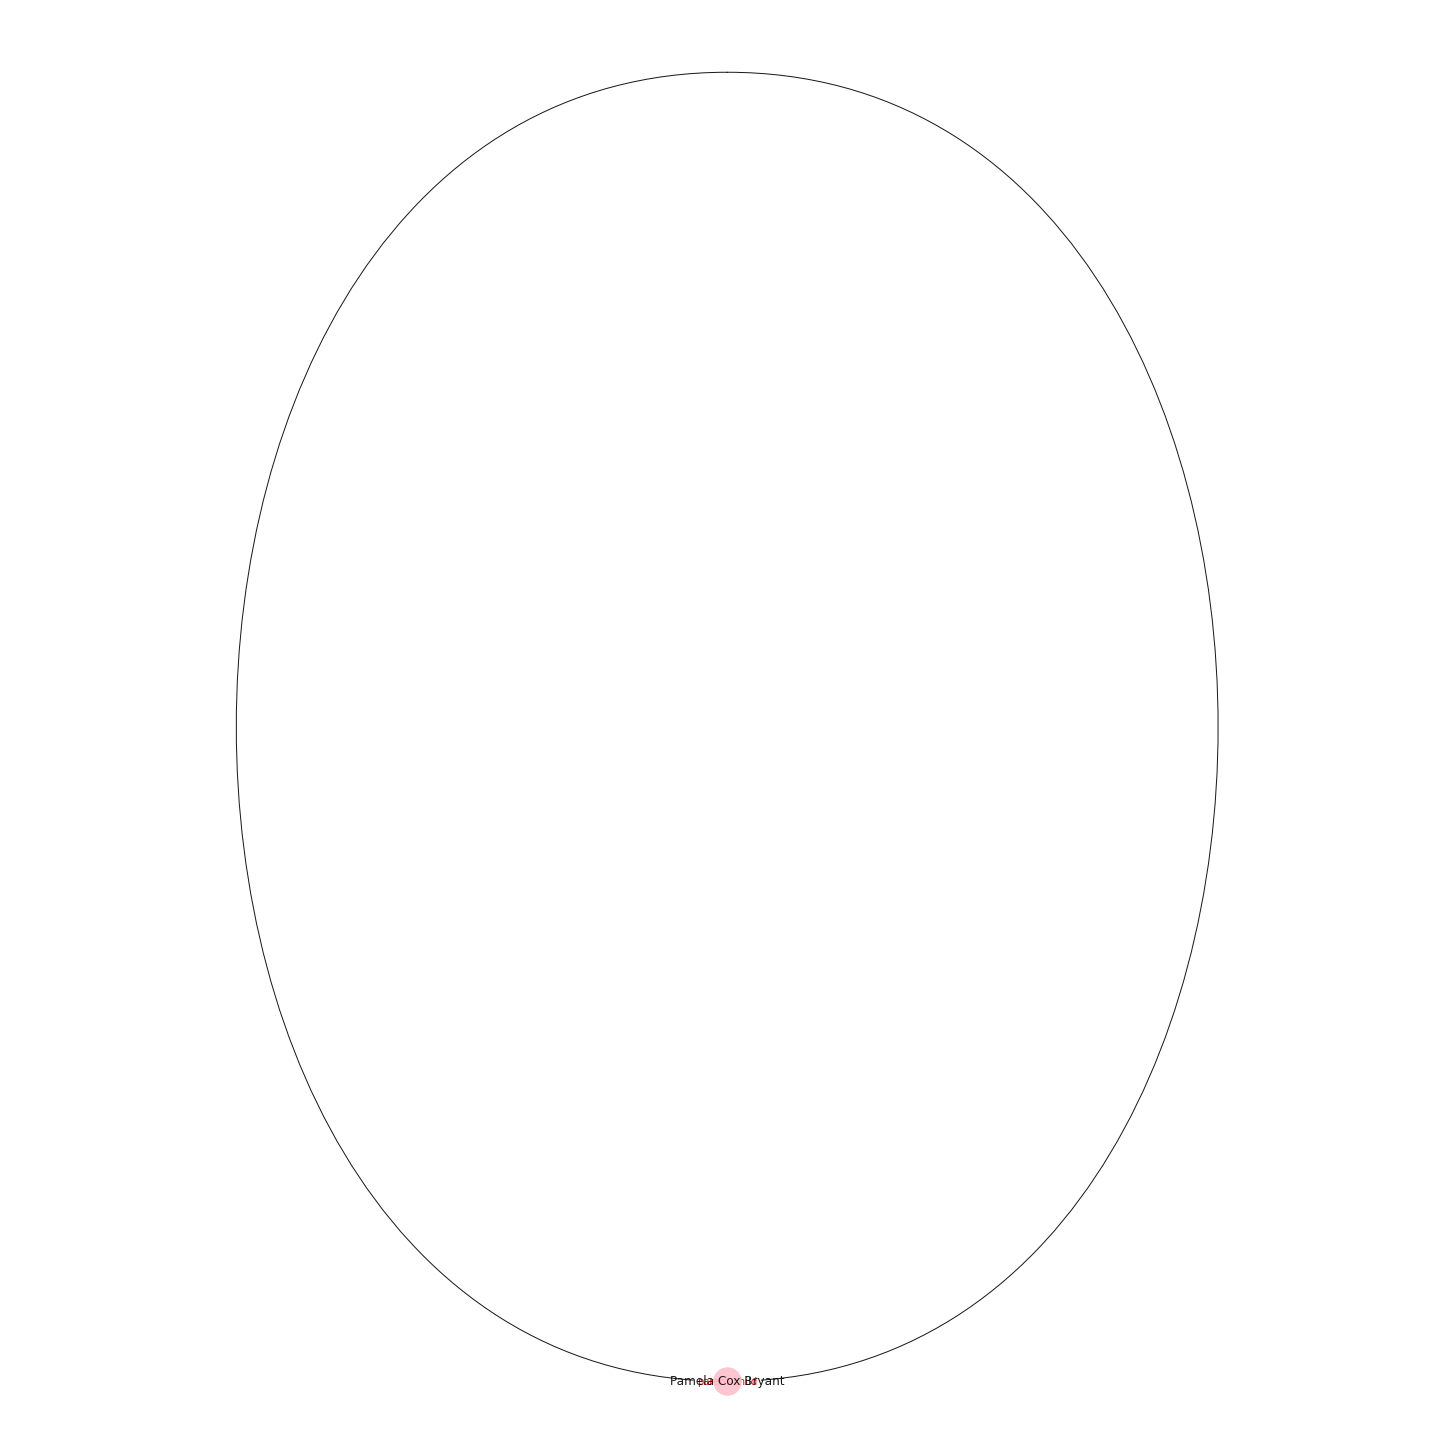

In [235]:
for ents, rel in GG.e_labels.items():
        if rel['label'] != 'no-rel':
                GG.G.add_edge(ents[0], ents[1])

plt.figure(figsize=(20,20))
pos = nx.spring_layout(GG.G)
nx.draw(
    GG.G, pos, edge_color='black', width=1, linewidths=1,
    node_size=750, node_color='pink', alpha=0.9,
    labels={node : node.text for node in GG.G.nodes()}
)
nx.draw_networkx_edge_labels(
    GG.G, pos,
    edge_labels={ents : rel['label'] for ents, rel in GG.e_labels.items()},
    font_color='red'
)

display(GG.G)

In [55]:
from transformers import pipeline, AutoTokenizer
model_pipeline = pipeline(task='text-classification',
                          model=my_model,
                          tokenizer=AutoTokenizer.from_pretrained("bert-base-cased"))

In [217]:
model_pipeline(['[E1] Mary [/E1] is the sister of [E2] Mark [/E2]',
                'Mary is the sister of Mark',
                '[E1] Jonathan [/E1] is the long-lost friend of [E2] Beatrice [/E2]',
                'Quintavius is the long-lost friend of Elizabeth',
                'Smith and [E1] Johnny [/E1] brother [E1] Ethan [/E1] own Treybal'
               ])

[{'label': 'siblings', 'score': 0.5686220526695251},
 {'label': 'no-rel', 'score': 0.8433283567428589},
 {'label': 'marriage', 'score': 0.5537773370742798},
 {'label': 'no-rel', 'score': 0.6881057024002075},
 {'label': 'siblings', 'score': 0.9575772285461426}]

In [ ]:
def clean_wikitext(text):
    cleaned = re.sub(r'\[.{1,3}\]', '', text)
    cleaned = re.sub(r' \(([^\)]*[^\)]*?)\)', '', cleaned)
    return cleaned

MAX_SPAN_LEN = 120

paragraph = '''
Kimberly Noel Kardashian was born on October 21, 1980, in Los Angeles, California, to Robert and Kris Kardashian (née Houghton).[18] She has an older sister, Kourtney, a younger sister, Khloé, and a younger brother, Rob.[19] Their mother is of Dutch, English, Irish, and Scottish ancestry,[20] while their father was a third-generation Armenian-American.[21] After their parents divorced in 1991, her mother married again that year, to Bruce Jenner,[a] the 1976 Summer Olympics decathlon winner.[23] Through their marriage, Kim Kardashian gained step-brothers Burton "Burt", Brandon, and Brody; step-sister Casey; and half-sisters Kendall and Kylie Jenner.[24]
'''

test_doc = clean_wikitext(paragraph)
test_doc = nlp(test_doc)
ents = get_relevant_annotations(test_doc)
clust_pairs = get_cluster_pairs(test_doc)
clust_dict = defaultdict(lambda: [])
for refers2, coref in clust_pairs:
    for c in coref:
        clust_dict[c].append(refers2)

clust_pairs[0][0][0] in ents
        
# for i in range(len(ents)):
#     for j in range(i + 1, len(ents)):
#         span = test_doc[ents[i].start_char : ents[j].end_char]
#         if len(span) < MAX_SPAN_LEN:
#             print(span)
# print(ents)
# print(clust_pairs)
# print(clust_dict)

In [ ]:
predictions = model_pipeline([r for ents, r in rels])
predictions[:10]

In [ ]:
import networkx as nx
G = nx.Graph()
e_labels = {}

for i in range(len(predictions)):
    if predictions[i]['label'] != 'OTHER' and predictions[i]['score'] > 0.85:
        G.add_edge(rels[i][0][0], rels[i][0][1], edge_label=predictions[i]['label'])
        if (rels[i][0][0], rels[i][0][1]) not in e_labels:
            e_labels[(rels[i][0][0], rels[i][0][1])] = predictions[i]['label']
        
G

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,18))
pos = nx.spring_layout(G)
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=750, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=e_labels,
    font_color='red'
)

In [371]:
my_df['data'].loc[44]

{'text': 'Montealegre was born on March 3, 1922 in San José, Costa Rica to Clemencia Montealegre Carazo, and Roy Elwood Cohn, a US mining executive then stationed in Costa Rica. Educated in Chile she was raised Catholic, and later converted to Judaism, when marrying Leonard Bernstein. She established herself in New York, where she took piano lessons from her Chilean compatriot Claudio Arrau.'}

In [372]:
to_combine = [
    [3],
    [4],
    [5],
    [6],
    [7, 8],
    [9, 10],
    [11, 12, 13, 14, 15, 16, 17],
    [18, 19, 20, 21],
    [22, 23, 24],
    [25, 26],
    [27, 28],
    [29],
    [30],
    [31],
    [32, 33, 34],
    [35],
    [36],
    [37, 38, 39, 40, 41, 42, 43],
    [44, 45],
    [46, 47],
    [48],
    [49, 50],
    [51, 52]   
]

In [373]:
with open('ARCHIVE.json', 'r') as f:
    data = json.load(f)

final = []
task2dict = {d['id'] : d for d in data}
# task2dict[7]['data']['text']
for docs2combine in to_combine:
    ref = task2dict[docs2combine[0]]
    new_text = ref['data']['text']
    text_len = len(new_text)
    offset = text_len + 2 # 2 newlines + first character
    original_ents = ref['annotations'][0]['result']
    # print(ref['data']['text'])
    for other in docs2combine[1:]:
        other_doc = task2dict[other]
        for ent in other_doc['annotations'][0]['result']:
            if ent['type'] == 'labels':
                ent['value']['start'] += offset
                ent['value']['end'] += offset
            original_ents.append(ent)
        new_text = new_text + '\n\n' + other_doc['data']['text']
        text_len = len(new_text)
        offset = text_len + 2 # 2 newlines
    ref['data']['text'] = new_text
    final.append(copy.deepcopy(ref))
    
# print(ref['data']['text'])

In [374]:
with open('test.json', 'w') as f:
    json.dump(final, f)

In [371]:
final

[{'id': 7,
  'annotations': [{'id': 8,
    'completed_by': 1,
    'result': [{'value': {'start': 0,
       'end': 14,
       'text': 'Schwarzenegger',
       'labels': ['entity']},
      'id': 'Ww3NT0QsfN',
      'from_name': 'label',
      'to_name': 'txt-99',
      'type': 'labels',
      'origin': 'prediction-changed'},
     {'value': {'start': 75, 'end': 80, 'text': 'Arnie', 'labels': ['entity']},
      'id': 'JTZ1y-n_s1',
      'from_name': 'label',
      'to_name': 'txt-99',
      'type': 'labels',
      'origin': 'prediction-changed'},
     {'value': {'start': 184,
       'end': 197,
       'text': 'Maria Shriver',
       'labels': ['entity']},
      'id': 'ACHTjDkouP',
      'from_name': 'label',
      'to_name': 'txt-99',
      'type': 'labels',
      'origin': 'prediction-changed'},
     {'value': {'start': 220,
       'end': 235,
       'text': 'John F. Kennedy',
       'labels': ['entity']},
      'id': 'Y9hp5gkSeZ',
      'from_name': 'label',
      'to_name': 'txt-99',
  